### Clustering Analysis of Race Tracks

In [15]:
import numpy as np
import pandas as pd
import scipy 
import scipy.stats
from scipy import stats
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from itertools import groupby
import pickle
import os
import math
from sympy import S, symbols
from string import digits
from numpy import *

from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')
#sns.mpl.rcParams['figure.figsize'] = (16, 10)

# Directory to store pickled dataframes
directory = '/Users/dianaow/Documents/formula-1-race-data/dataframes/'

In [16]:
sns.set_palette("Set1", 8, .75)

In [17]:
def read_from_pickle(directory, filename):
    df = pd.DataFrame()
    filepath = directory + filename
    with open(filepath, 'rb') as file:
        df = pickle.load(file)
            
    return df

In [18]:
xl = pd.ExcelFile("/Users/dianaow/Downloads/F1_Tyre_data.xlsx")
xl.sheet_names
pirelli = xl.parse("Sheet7")

In [19]:
xl = pd.ExcelFile("./formula-1-race-data/Selected_Sets.xlsx", encoding='utf-8')
xl.sheet_names
selected_sets = xl.parse("Sheet10")

In [20]:
xl = pd.ExcelFile("./formula-1-race-data/Track_Information.xlsx", encoding='utf-8')
xl.sheet_names
track_info = xl.parse("Copy of Sheet12")
# Pirelli did not release information about certain tracks in 2016 .
# They have been inputed with 2017's values

In [21]:
xl = pd.ExcelFile("./formula-1-race-data/Race_Information.xlsx", encoding='utf-8')
xl.sheet_names
track = xl.parse("Sheet12")

In [46]:
xl = pd.ExcelFile("/Users/dianaow/Downloads/F1_Tyre_data.xlsx")
xl.sheet_names
pirelli = xl.parse("Sheet7")

## Perform K-means clustering on Race Tracks based on published track information

#### Pre-processing steps

In [22]:
track['Air Temp(mean)'] = (track['Air Temp (highest)'] + track['Air Temp (lowest)']) /2
track['Air Temp(range)'] = (track['Air Temp (highest)'] - track['Air Temp (lowest)'])
track['Track Temp(mean)'] = (track['Track Temp (highest)'] + track['Track Temp (lowest)']) /2
track['Track Temp(range)'] = (track['Track Temp (highest)'] - track['Track Temp (lowest)'])

In [23]:
track.describe()

Year  Air Temp (lowest)  Air Temp (highest)  \
count    58.000000          40.000000           40.000000   
mean   2015.017241          22.157500           24.042500   
std       0.805494           5.551802            5.645052   
min    2014.000000          12.100000           13.100000   
25%    2014.000000          17.300000           19.250000   
50%    2015.000000          21.950000           24.600000   
75%    2016.000000          25.600000           28.350000   
max    2016.000000          32.700000           35.400000   

       Track Temp (lowest)  Track Temp (highest)  Air Temp(mean)  \
count            58.000000             58.000000       40.000000   
mean             32.341379             37.806897       23.100000   
std               9.061312             10.612205        5.577036   
min              17.800000             19.400000       12.600000   
25%              26.400000             29.475000       18.612500   
50%              32.000000             36.600000       23.275000   
75%              38.100000             45.625000       26.975000   
max              53.000000             61.400000       34.050000   

       Air Temp(range)  Track Temp(mean)  Track Temp(range)  
count        40.000000         58.000000          58.000000  
mean          1.885000         35.074138           5.465517  
std           0.982292          9.723169           3.360428  
min           0.400000         18.600000           1.400000  
25%           1.300000         27.312500           2.525000  
50%           1.600000         34.175000           4.700000  
75%           2.325000         41.762500           7.625000  
max           4.000000         57.200000          14.200000

In [24]:
track[(track["Weather (prev year)"] == "Rain") | (track["Weather (prev year)"] == "Rainy/Cloudy") | (track["Weather (prev year)"] == "Cloudy/Rainy")]

Year                  Race Weather (prev year)  Air Temp (lowest)  \
10  2014   Japanese Grand Prix        Rainy/Cloudy                NaN   
24  2015  Brazilian Grand Prix                Rain               18.1   
25  2015    British Grand Prix        Cloudy/Rainy               17.3   
45  2016  Brazilian Grand Prix                Rain               18.1   
46  2016    British Grand Prix        Cloudy/Rainy               17.3   
53  2016     Monaco Grand Prix        Rainy/Cloudy               17.2   

    Air Temp (highest)  Track Temp (lowest)  Track Temp (highest)  \
10                 NaN                 21.9                  23.5   
24                18.5                 19.5                  21.4   
25                21.1                 21.6                  28.6   
45                18.5                 19.5                  21.4   
46                21.1                 21.6                  28.6   
53                18.8                 19.1                  25.4   

    Air Temp(mean)  Air Temp(range)  Track Temp(mean)  Track Temp(range)  
10             NaN              NaN             22.70                1.6  
24            18.3              0.4             20.45                1.9  
25            19.2              3.8             25.10                7.0  
45            18.3              0.4             20.45                1.9  
46            19.2              3.8             25.10                7.0  
53            18.0              1.6             22.25                6.3

In [25]:
track_new = pd.merge(track, track_info, on="Race", how='left')
track_new = track_new.drop(['Air Temp (lowest)', 'Air Temp (highest)', 'Track Temp (lowest)', 'Track Temp (highest)', 
                        "Weather (prev year)", ], axis=1)

#### Check for correlation

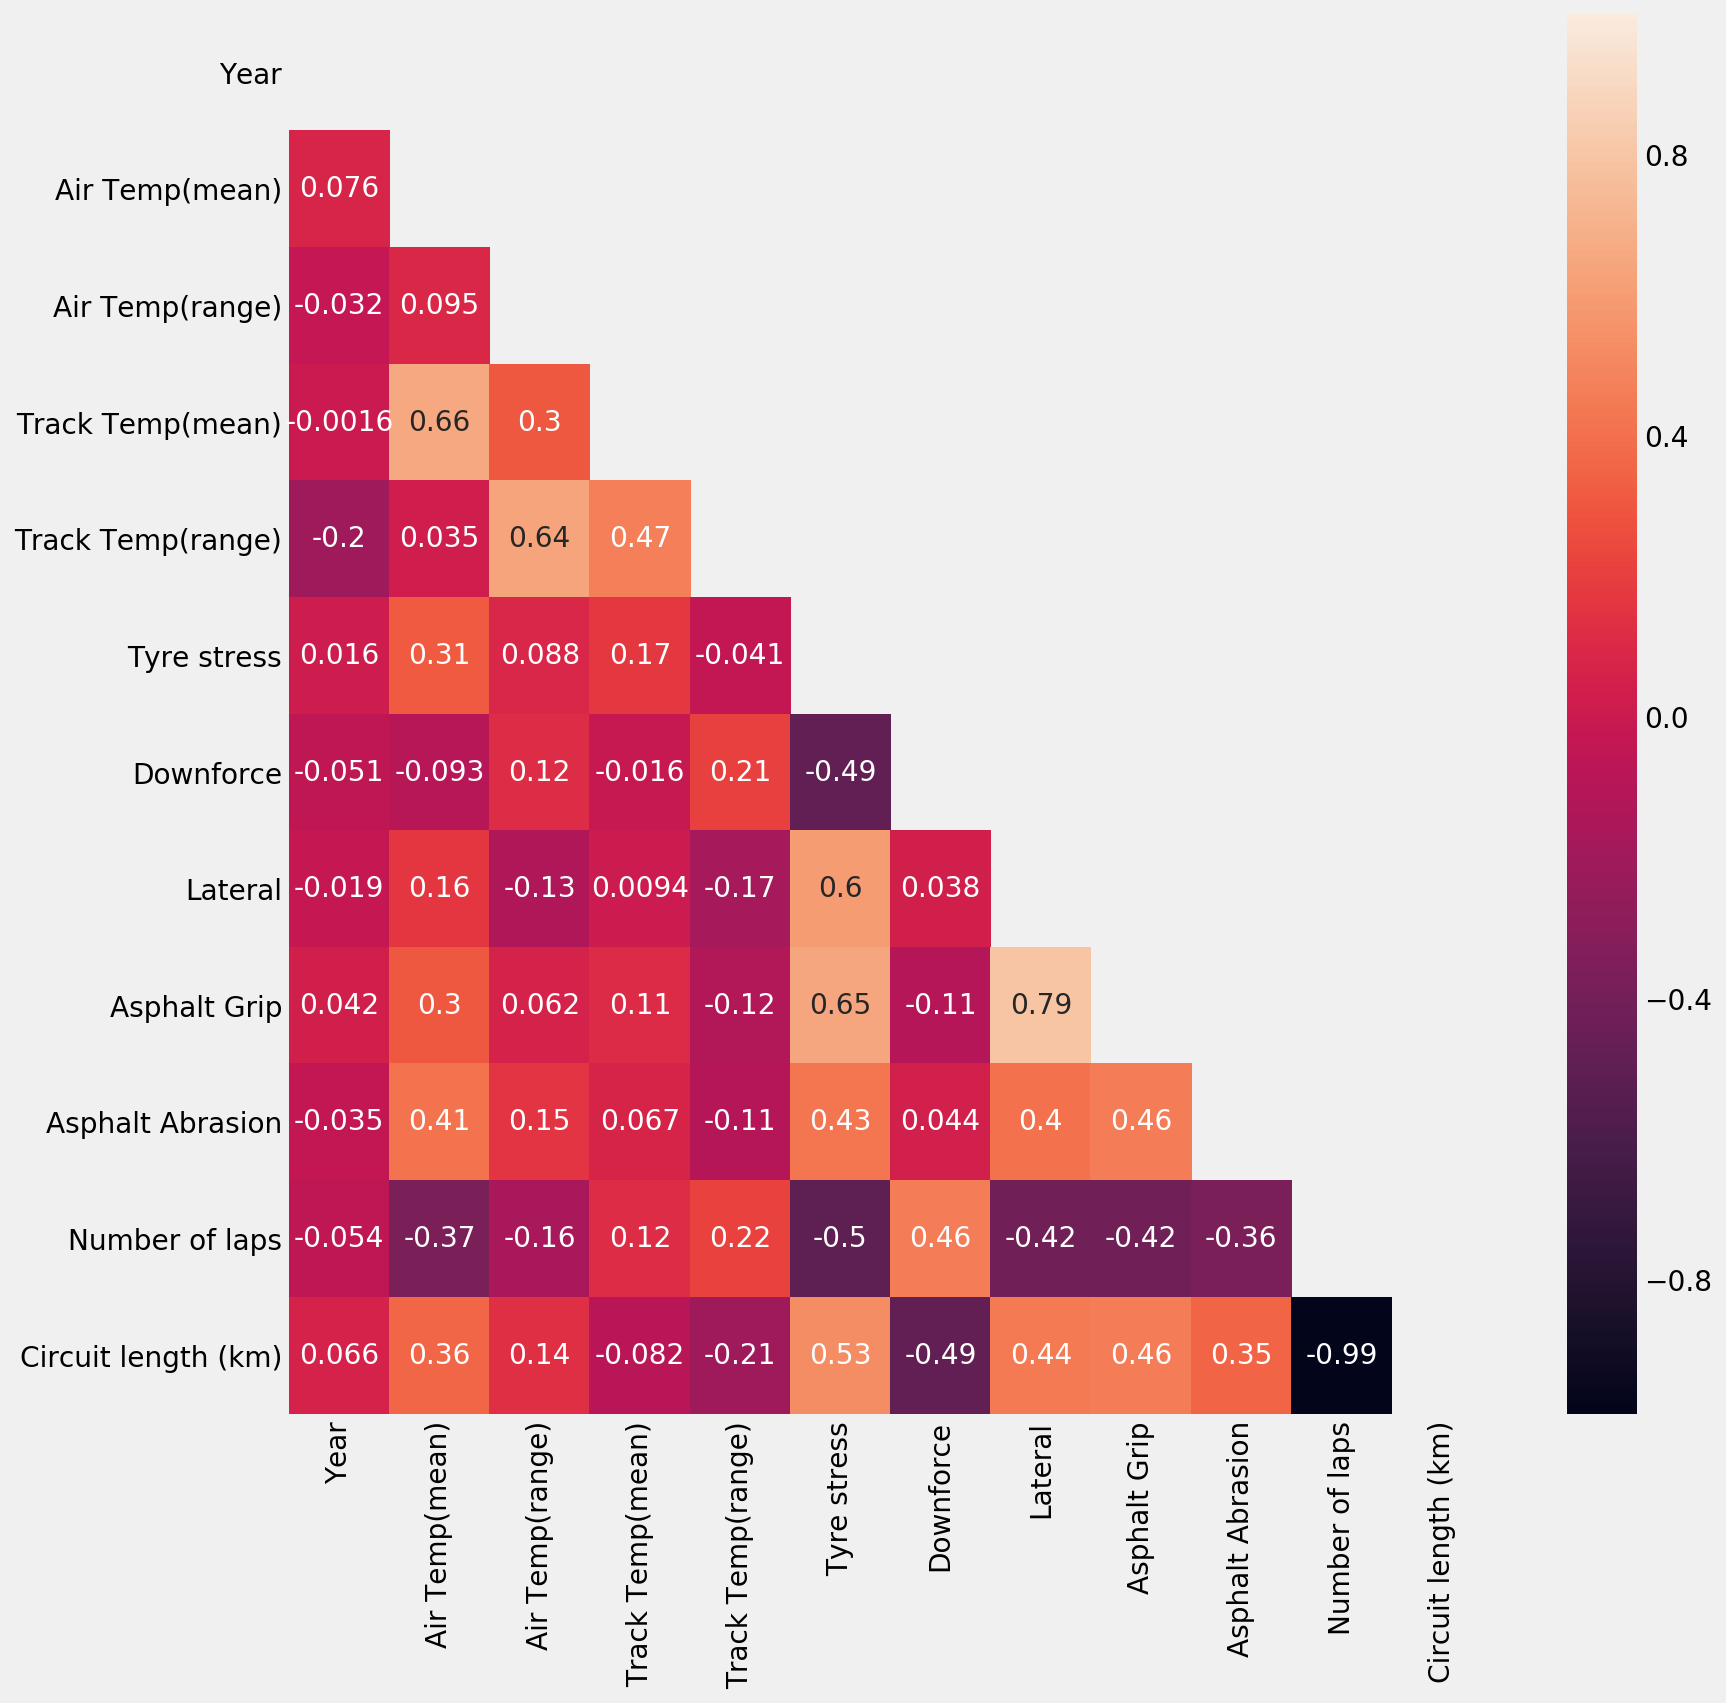

In [26]:
# remove asphalt grip  as it has a high correlation with lateral and tyre stress
# remove air temp (mean) as it has a high correlation with track temp (mean)
# remove air temp (range) as it has a high correlation with track temp (range)
def gen_mask(df):
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True         
    return mask

fig, ax = plt.subplots(figsize=(12,12))  
sns.heatmap(track_new.corr(), mask=gen_mask(track_new.corr()), annot=True,ax=ax)

In [28]:
track_new = track_new.drop(['Asphalt Grip', 'Air Temp(mean)', 'Air Temp(range)', 'Circuit length (km)'], axis=1)

In [33]:
track_new_agg = track_new.groupby('Race').agg("mean").reset_index()

### Features:
- 1) Average track temperature (from 2014 to 2017)
- 2) Range of Track Temperature(from 2014 to 2017)
- 3) Tyre Stress Rate
- 4) Downforce Rate
- 5) Asphalt Abrasion
- 6) Number of race laps
- 7) Circuit length

Features 3 to 7 remain constant between seasons

### Apply K-Means Clustering

In [41]:
X = track_new_agg.drop(['Year', 'Race'], axis=1)
Y = track_new_agg[['Race']]

In [35]:
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

# create dataframe to append info too
results = pd.DataFrame(columns = ['k','silhouette','processing'])
ran = range(2,10)

def cluster(ran, data, version):
    for k in ran:
        k_means = KMeans(n_clusters=k)
        k_means.fit(data)
        labels = k_means.labels_
        score = silhouette_score(data, labels)
        results.loc[len(results)]=['c'+str(k), score, version]

In [36]:
def opt_cluster(ran, data):
    cluster(ran, data, 'default')
    
    # normalized version
    Xn = normalize(data)
    cluster(ran, Xn, 'normalized')
    
    # standard scale version
    SS = StandardScaler()
    Xs = SS.fit_transform(data)
    cluster(ran, Xs, 'standard_scaler')
    
    # minmax scale version
    MM = MinMaxScaler()
    Xmm = MM.fit_transform(data)
    cluster(ran, Xmm, 'min_max_scaler')

    return results.loc[results['silhouette'].idxmax()]

In [37]:
opt_cluster(ran, X)

k                  c3
silhouette    0.48901
processing    default
Name: 1, dtype: object

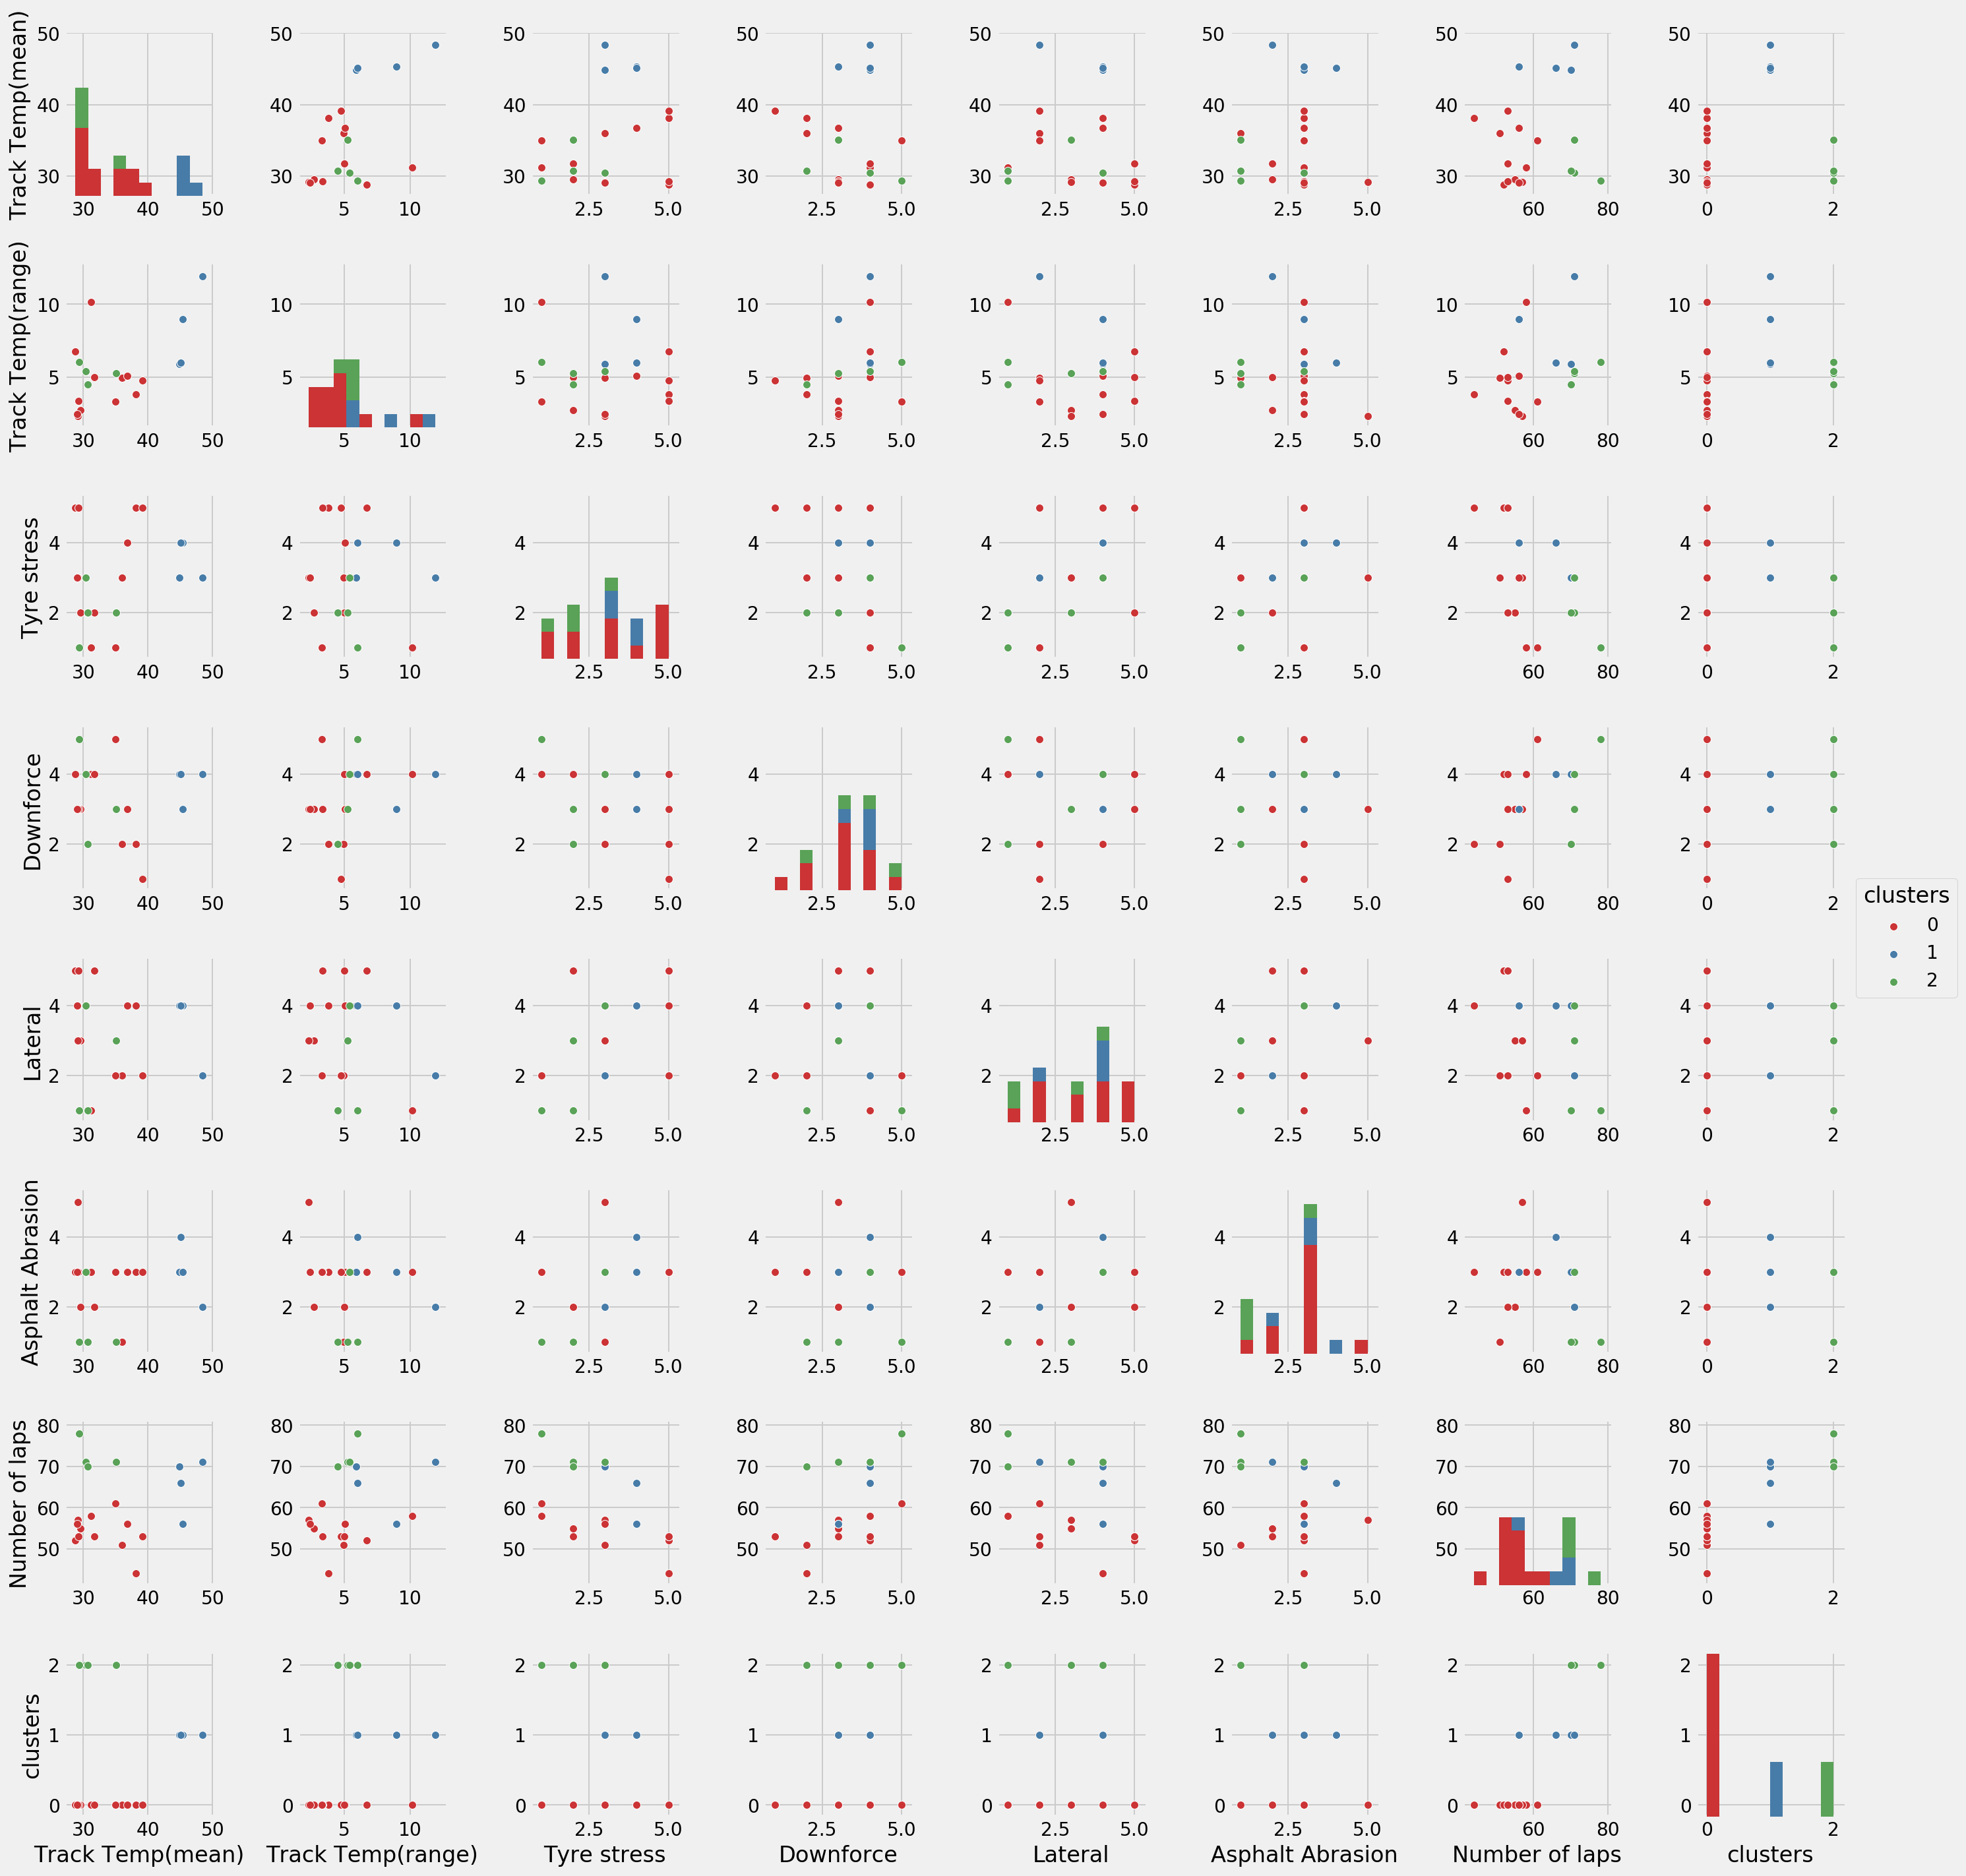

In [39]:
# build the model with the found optimal parameters
k_mean_opt = KMeans(n_clusters=3)
k_mean_opt.fit(X)
labels_opt = k_mean_opt.labels_

X_opt = track_new_agg.drop(["Year", "Race"], axis=1)

X_opt['clusters']=labels_opt
sns.pairplot(data=X_opt, hue='clusters')

#### RESULTS: Cluster groupings of race tracks based on track information 

In [42]:
clusters = pd.concat([X_opt, Y], axis=1)
clusters.sort_values('clusters')

Track Temp(mean)  Track Temp(range)  Tyre stress  Downforce  Lateral  \
0          29.516667           2.700000          2.0        3.0      3.0   
17         34.983333           3.300000          1.0        5.0      2.0   
16         31.733333           5.000000          2.0        4.0      5.0   
12         29.216667           3.366667          5.0        3.0      5.0   
11         39.116667           4.766667          5.0        1.0      2.0   
7          28.766667           6.733333          5.0        4.0      5.0   
9          36.766667           5.066667          4.0        3.0      4.0   
5          38.100000           3.800000          5.0        2.0      4.0   
4          29.150000           2.300000          3.0        3.0      3.0   
3          35.975000           4.950000          3.0        2.0      2.0   
1          31.150000          10.166667          1.0        4.0      1.0   
19         29.050000           2.433333          3.0        3.0      4.0   
18         45.100000           6.000000          4.0        4.0      4.0   
10         44.883333           5.900000          3.0        4.0      4.0   
13         45.350000           8.966667          4.0        3.0      4.0   
14         48.400000          11.933333          3.0        4.0      2.0   
8          30.683333           4.500000          2.0        2.0      1.0   
15         29.350000           6.033333          1.0        5.0      1.0   
2          35.100000           5.266667          2.0        3.0      3.0   
6          30.400000           5.400000          3.0        4.0      4.0   

    Asphalt Abrasion  Number of laps  clusters                      Race  
0                2.0            55.0         0      Abu Dhabi Grand Prix  
17               3.0            61.0         0      Singapore Grand Prix  
16               2.0            53.0         0        Russian Grand Prix  
12               3.0            53.0         0       Japanese Grand Prix  
11               3.0            53.0         0        Italian Grand Prix  
7                3.0            52.0         0        British Grand Prix  
9                3.0            56.0         0        Chinese Grand Prix  
5                3.0            44.0         0        Belgian Grand Prix  
4                5.0            57.0         0        Bahrain Grand Prix  
3                1.0            51.0         0     Azerbaijan Grand Prix  
1                3.0            58.0         0     Australian Grand Prix  
19               3.0            56.0         0  United States Grand Prix  
18               4.0            66.0         1        Spanish Grand Prix  
10               3.0            70.0         1      Hungarian Grand Prix  
13               3.0            56.0         1      Malaysian Grand Prix  
14               2.0            71.0         1        Mexican Grand Prix  
8                1.0            70.0         2       Canadian Grand Prix  
15               1.0            78.0         2         Monaco Grand Prix  
2                1.0            71.0         2       Austrian Grand Prix  
6                3.0            71.0         2      Brazilian Grand Prix

In [111]:
clusters.to_pickle(os.path.join(directory, "clusters.pickle"))

#### Check: Compare clustering results with actual mandatory tyre set assigned to the race per year
- Hypothesis is that Pirelli assigns tyre sets for circuits with similar characteristics

In [73]:
pirelli_drop = pirelli[['year', 'name', 'mandatory combi']]
pirelli_pt = pd.pivot_table(pirelli_drop, values='mandatory combi', index=['name'], columns=['year'])

In [74]:
clusters.columns = clusters.columns.str.lower()
clusters.rename(columns={"race":"name"}, inplace=True)
pm = pd.merge(clusters, pirelli_pt.reset_index(), on=['name'], how='left')
pm

track temp(mean)  track temp(range)  tyre stress  downforce  lateral  \
0          29.516667           2.700000          2.0        3.0      3.0   
1          31.150000          10.166667          1.0        4.0      1.0   
2          35.100000           5.266667          2.0        3.0      3.0   
3          35.975000           4.950000          3.0        2.0      2.0   
4          29.150000           2.300000          3.0        3.0      3.0   
5          38.100000           3.800000          5.0        2.0      4.0   
6          30.400000           5.400000          3.0        4.0      4.0   
7          28.766667           6.733333          5.0        4.0      5.0   
8          30.683333           4.500000          2.0        2.0      1.0   
9          36.766667           5.066667          4.0        3.0      4.0   
10         44.883333           5.900000          3.0        4.0      4.0   
11         39.116667           4.766667          5.0        1.0      2.0   
12         29.216667           3.366667          5.0        3.0      5.0   
13         45.350000           8.966667          4.0        3.0      4.0   
14         48.400000          11.933333          3.0        4.0      2.0   
15         29.350000           6.033333          1.0        5.0      1.0   
16         31.733333           5.000000          2.0        4.0      5.0   
17         34.983333           3.300000          1.0        5.0      2.0   
18         45.100000           6.000000          4.0        4.0      4.0   
19         29.050000           2.433333          3.0        3.0      4.0   

    asphalt abrasion  number of laps  clusters                      name  \
0                2.0            55.0         0      Abu Dhabi Grand Prix   
1                3.0            58.0         0     Australian Grand Prix   
2                1.0            71.0         2       Austrian Grand Prix   
3                1.0            51.0         0     Azerbaijan Grand Prix   
4                5.0            57.0         0        Bahrain Grand Prix   
5                3.0            44.0         0        Belgian Grand Prix   
6                3.0            71.0         2      Brazilian Grand Prix   
7                3.0            52.0         0        British Grand Prix   
8                1.0            70.0         2       Canadian Grand Prix   
9                3.0            56.0         0        Chinese Grand Prix   
10               3.0            70.0         1      Hungarian Grand Prix   
11               3.0            53.0         0        Italian Grand Prix   
12               3.0            53.0         0       Japanese Grand Prix   
13               3.0            56.0         1      Malaysian Grand Prix   
14               2.0            71.0         1        Mexican Grand Prix   
15               1.0            78.0         2         Monaco Grand Prix   
16               2.0            53.0         0        Russian Grand Prix   
17               3.0            61.0         0      Singapore Grand Prix   
18               4.0            66.0         1        Spanish Grand Prix   
19               3.0            56.0         0  United States Grand Prix   

    2015  2016  2017  
0    4.0   3.0   3.0  
1    7.0   1.0   3.0  
2    4.0   3.0   3.0  
3    NaN   1.0   1.0  
4    7.0   1.0   1.0  
5    7.0   1.0   3.0  
6    7.0   2.0   1.0  
7    6.0   2.0   1.0  
8    4.0   3.0   3.0  
9    7.0   1.0   1.0  
10   7.0   1.0   1.0  
11   7.0   1.0   1.0  
12   6.0   2.0   1.0  
13   6.0   2.0   1.0  
14   7.0   1.0   3.0  
15   4.0   3.0   3.0  
16   4.0   1.0   3.0  
17   4.0   3.0   3.0  
18   6.0   2.0   2.0  
19   7.0   1.0   3.0

## Perform K-means clustering on Race Tracks based on historical records of pit strategy and tyre usage of teams from 2015 to 2017

In [77]:
stints_15_16_17_clean = read_from_pickle(directory, "stints_15_16_17_clean.pickle")

In [78]:
def filter_df(df, string):
    cols = [col for col in df.columns if string in col]
    cols.append("name")
    cols.append("year")
    df_new = df.filter(cols)
    return df_new

In [79]:
m2015 = filter_df(stints_15_16_17_clean, "2015")
m2016 = filter_df(trendp_clean, "2016")
m2017 = filter_df(trendp_clean, "2017")

In [80]:
l = filter_df(stints_15_16_17_clean, "mean")
r = filter_df(stints_15_16_17_clean, "range")
c = filter_df(stints_15_16_17_clean, "count")
lr = pd.merge(l, r, on='name', how='left')

#### Are the "mean" and "range" columns correlated?

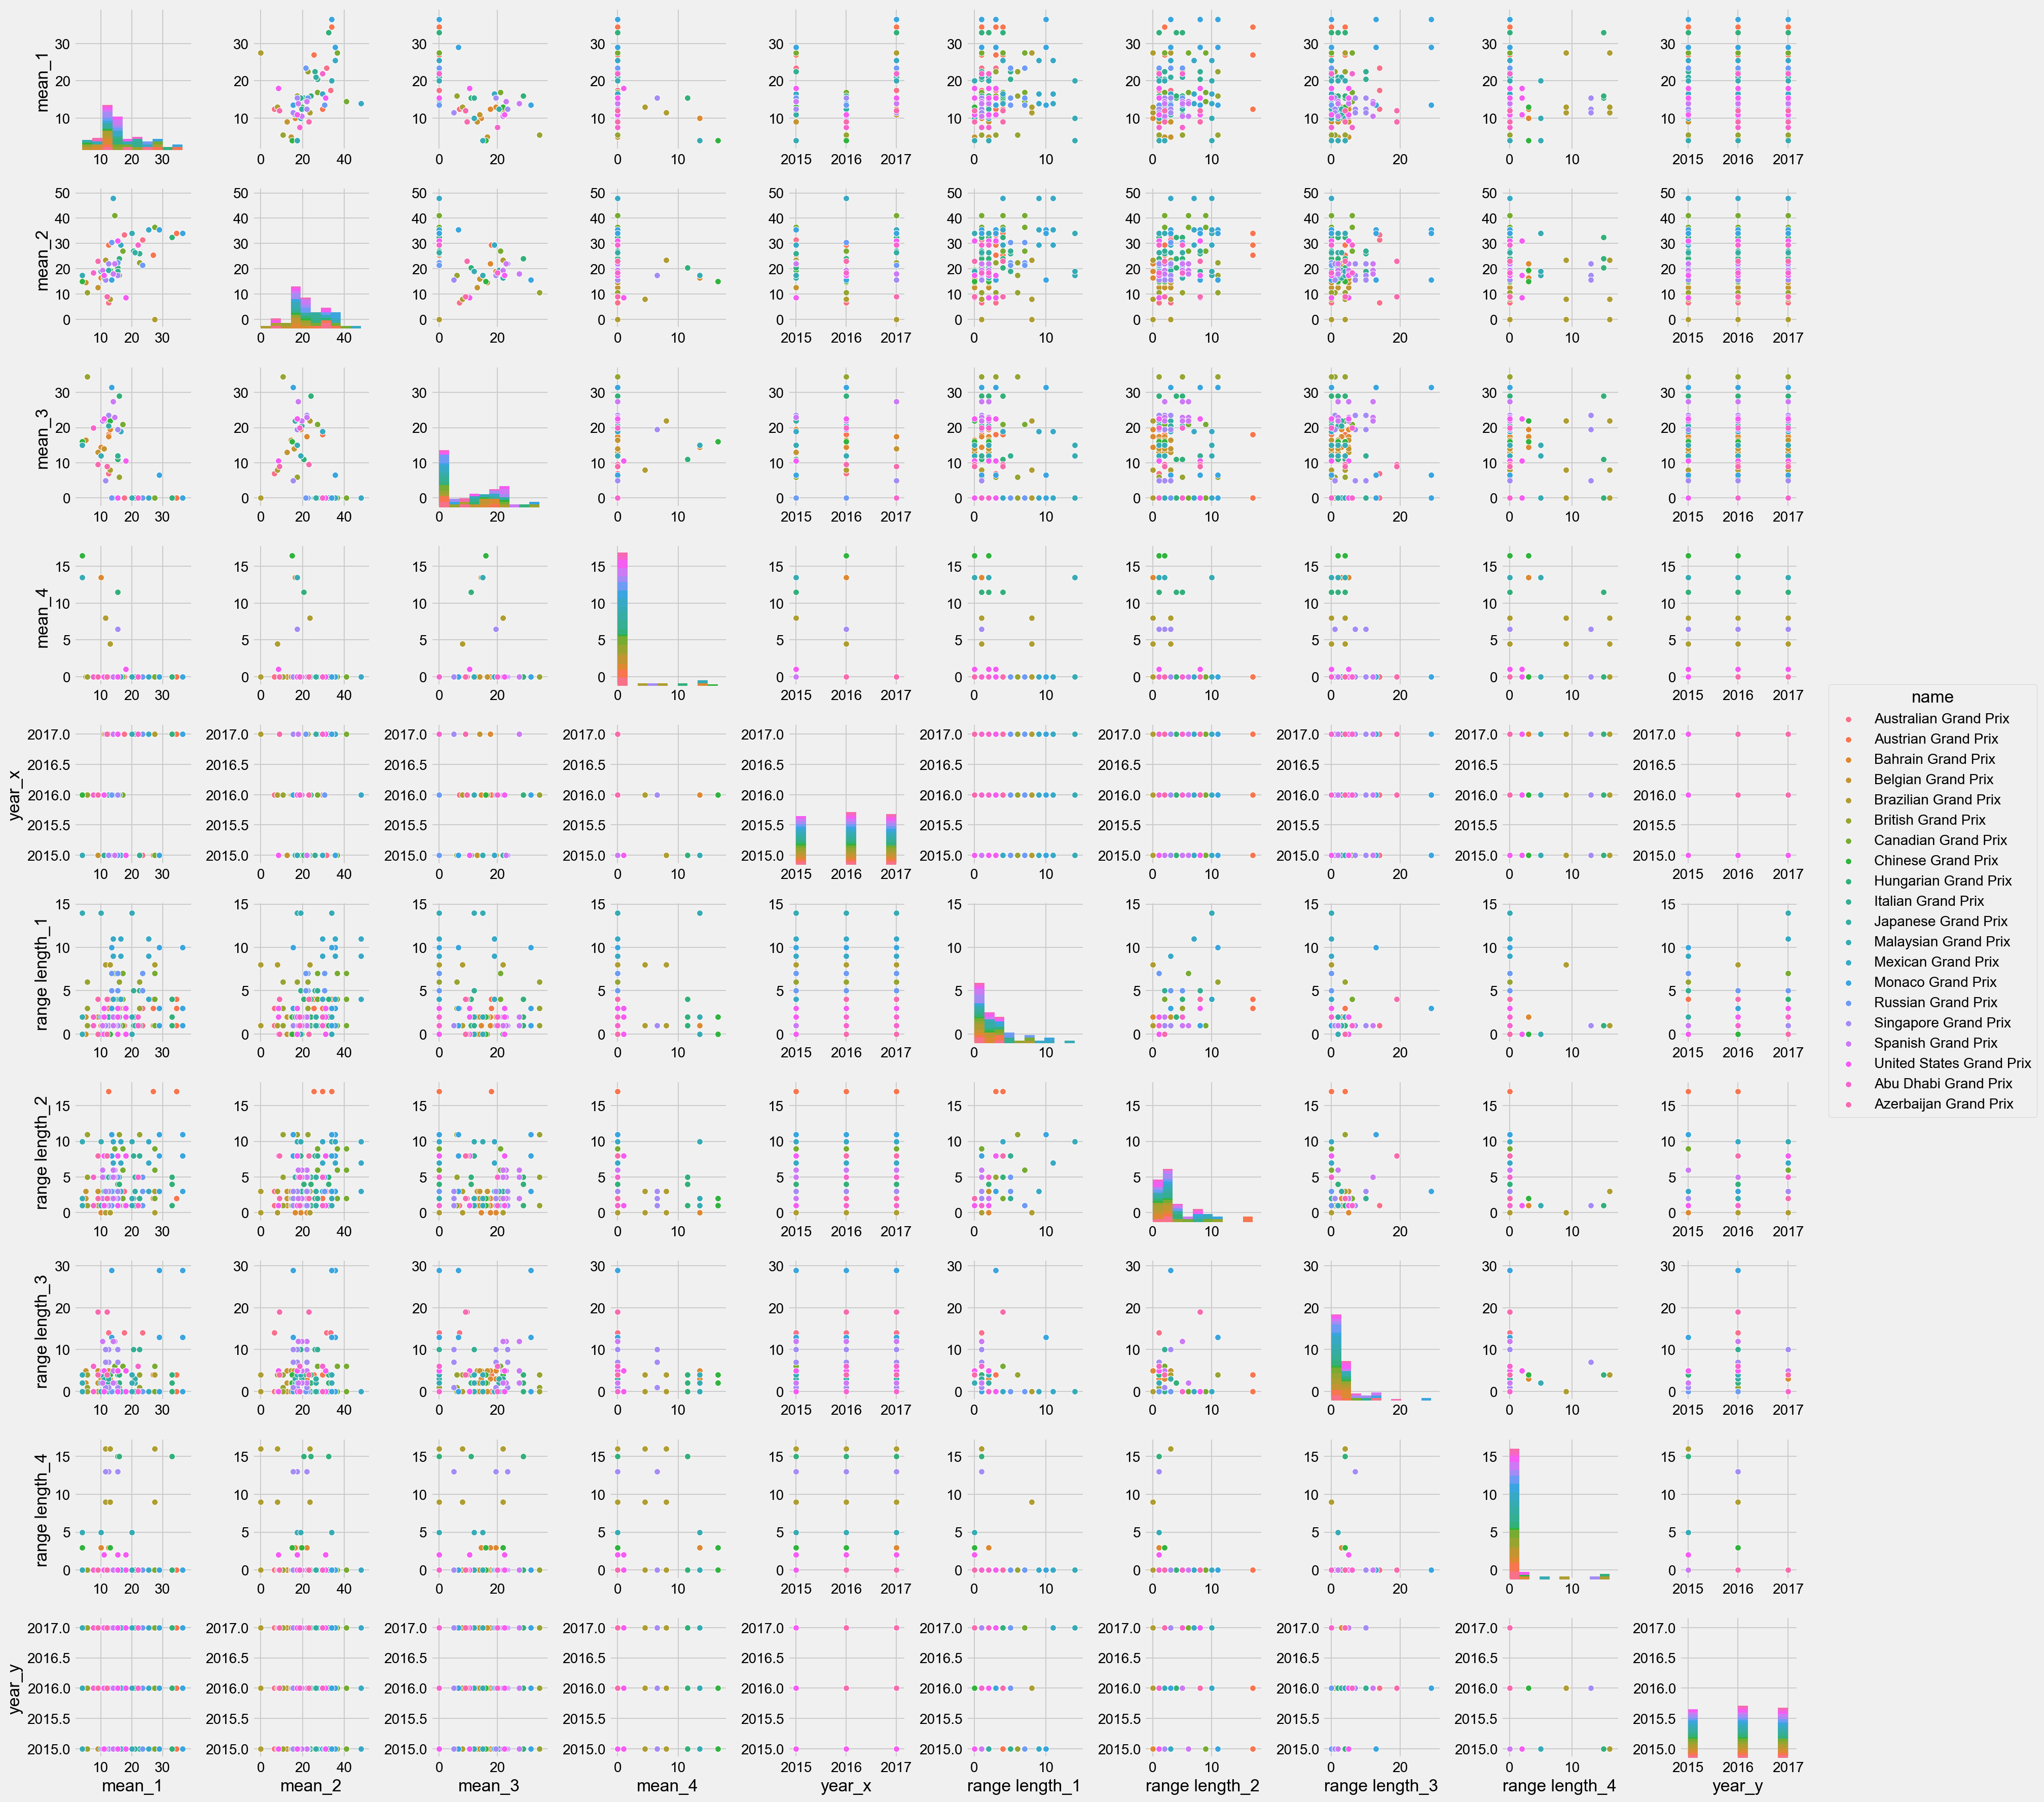

In [81]:
sns.pairplot(data=lr, hue='name')
sns.set(font_scale=1)

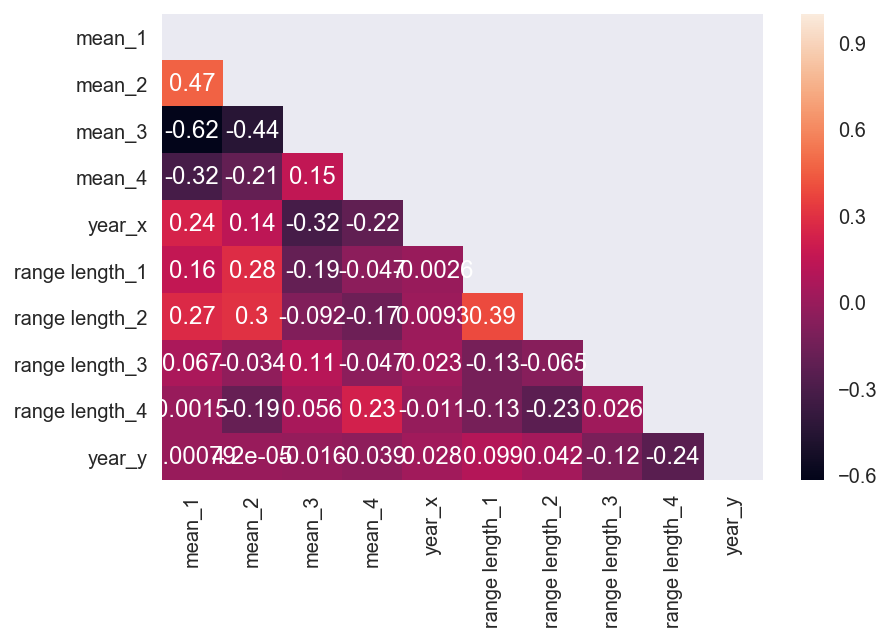

In [82]:
lr_corr = lr.corr() 

def gen_mask(df):
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True         
    return mask

sns.heatmap(lr_corr, mask=gen_mask(lr_corr), annot=True)

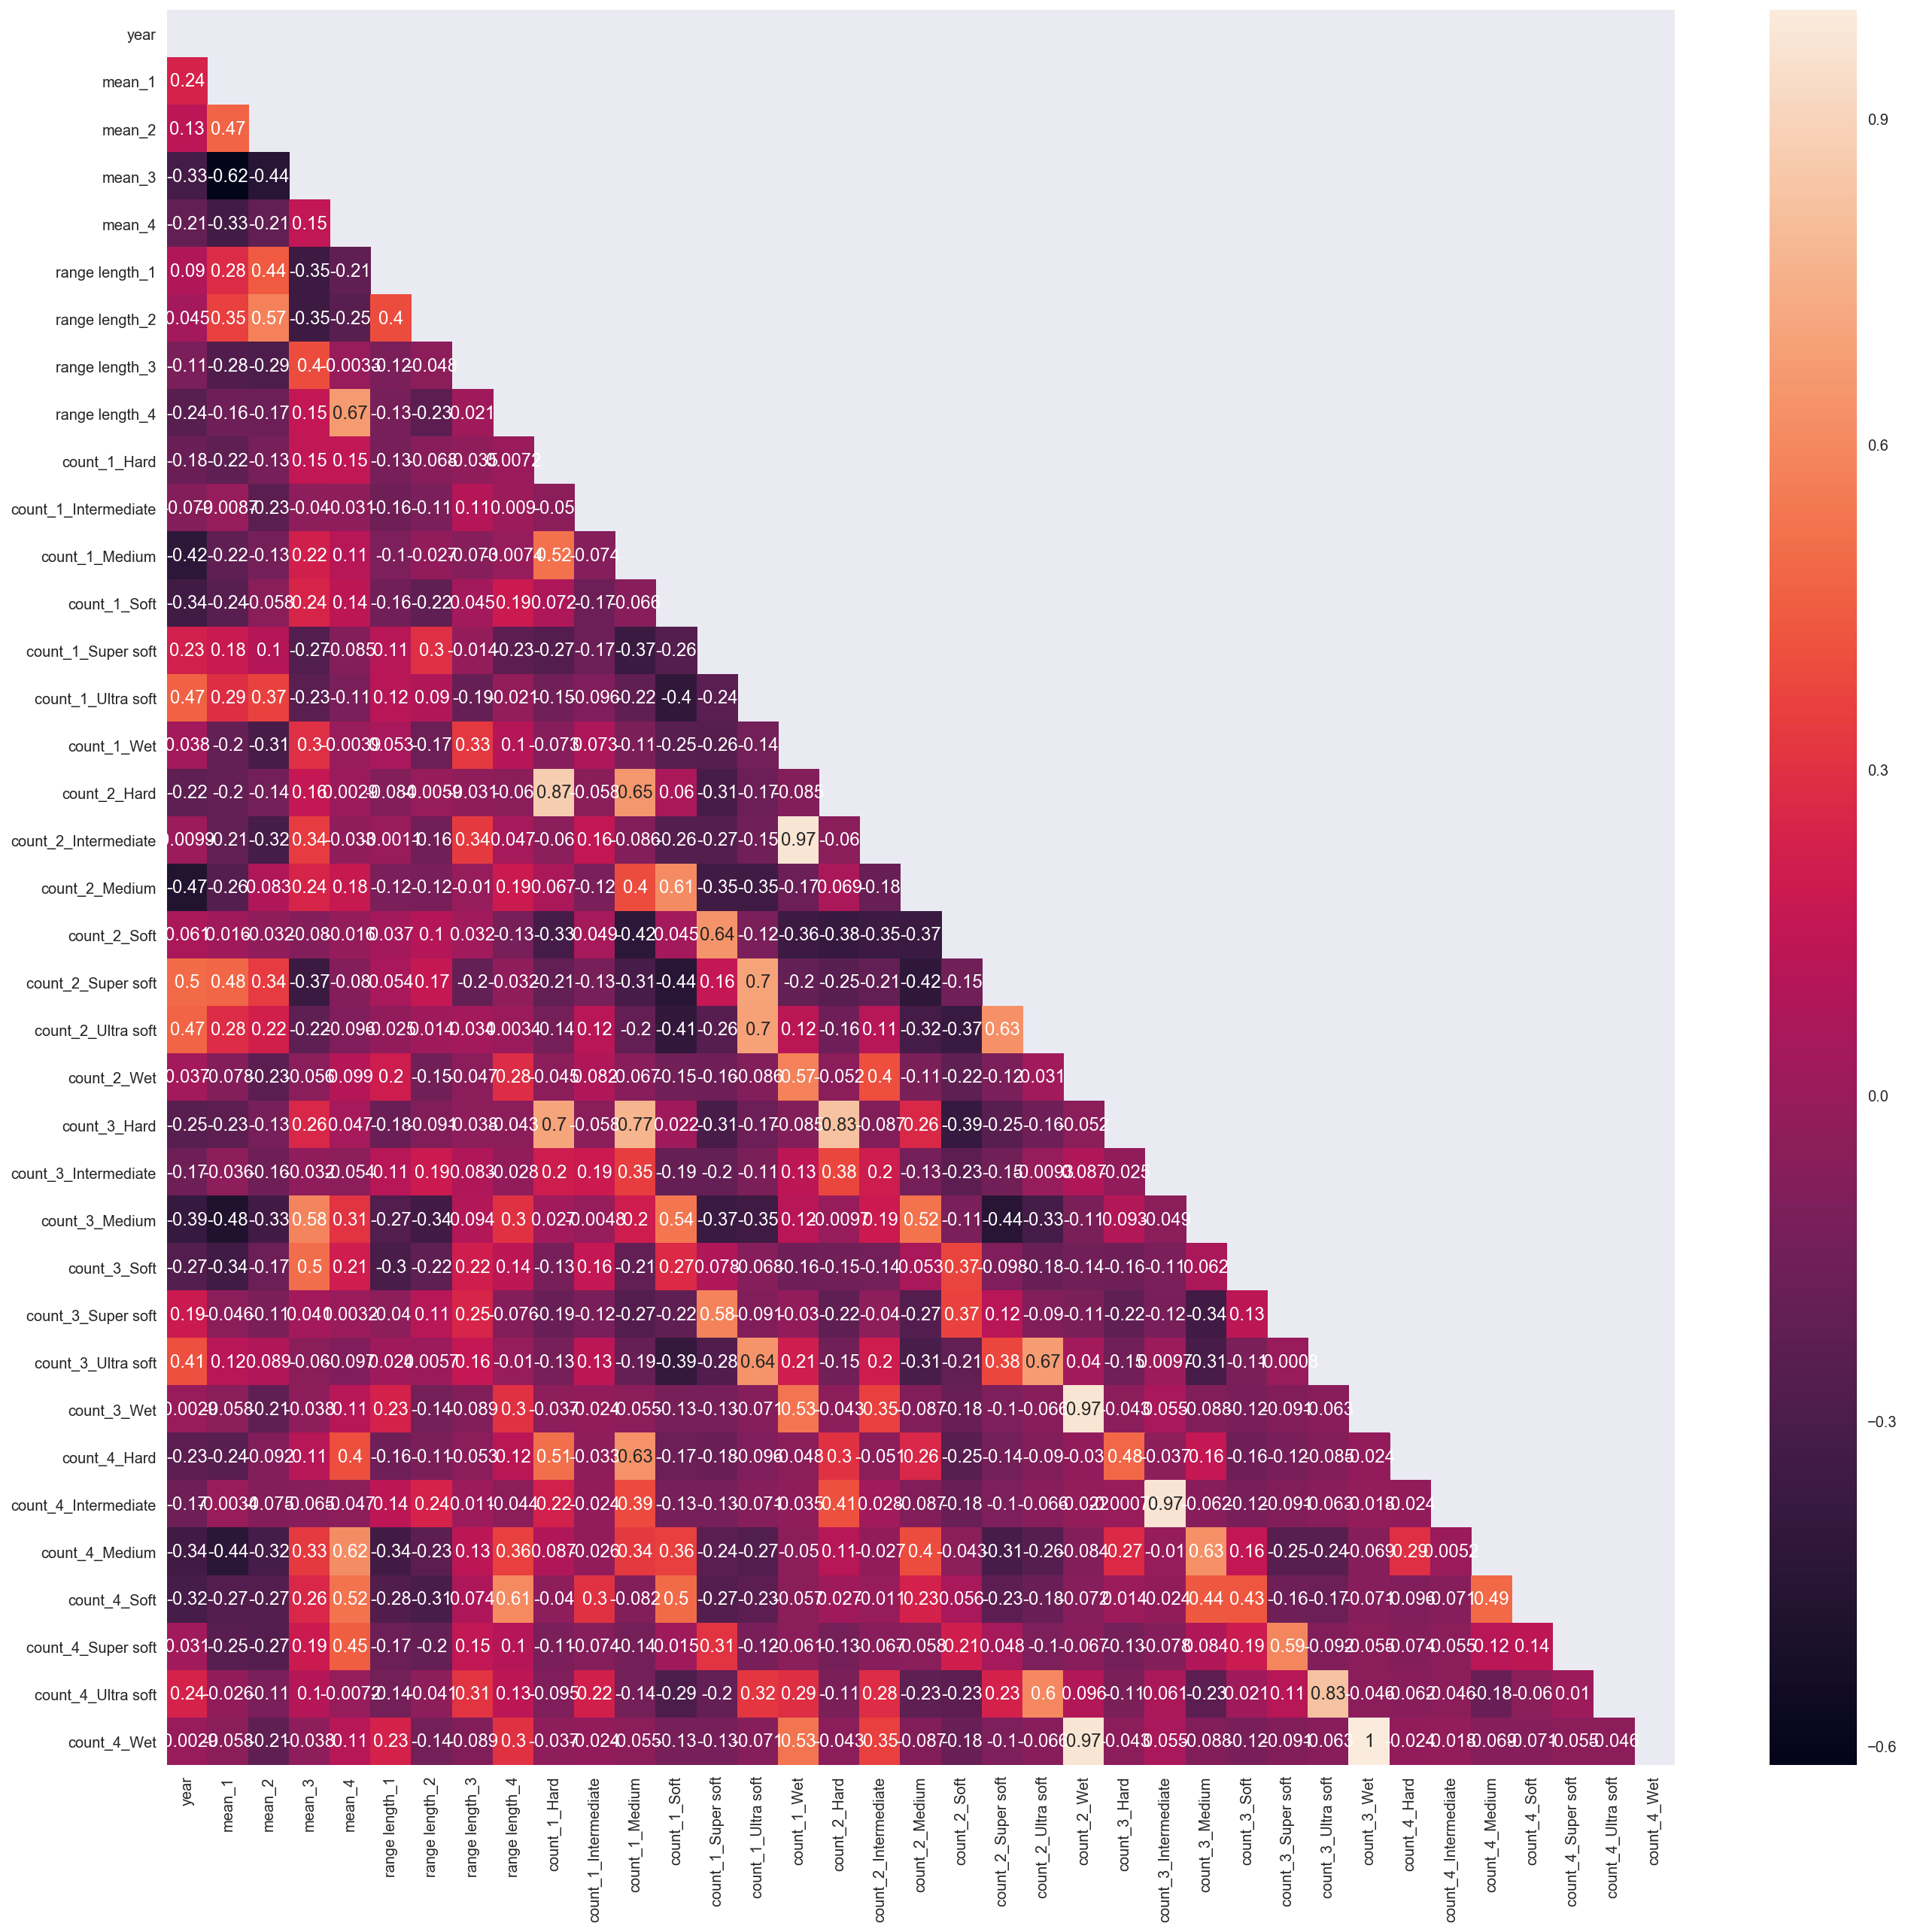

In [83]:
# Remove variables with correlation at or above 0.7
# Remove count_1_hard, count_1_wet,
# Remove count_2_ultrasoft, count_2_wet, count_3_hard,
# Remove count_4_wet, count_4_ultrasoft, count_4_intermediate

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(stints_15_16_17_clean.corr(), mask=gen_mask(stints_15_16_17_clean.corr()), annot=True, ax=ax)

In [84]:
clean_new = stints_15_16_17_clean.drop(['count_1_Hard', 'count_1_Wet',
                                        'count_2_Ultra soft', 'count_2_Wet', 'count_3_Hard', 
                                        "count_4_Wet", "count_4_Ultra soft", "count_4_Intermediate"], axis=1)

### Transform the dataset (consisting of 2015 to 2017 race strategy information) using PCA
- There is very high number of features (28) and I aim to "simplify/summarize" the data
- PCA looks to find a low-dimensional representation of the observation that explains a good fraction of the variance. - K-Means then applied on PCA-transformed dataset to find homogeneous subgroups among the observations.


In [85]:
from sklearn.decomposition import PCA

X = clean_new.iloc[:,2:].values
SS = StandardScaler()
Xs = SS.fit_transform(X)

pca = PCA()
pca.fit(Xs)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [86]:
components = pca.components_
len(components)

28

In [87]:
len(Xs)

57

In [88]:
pcs = pca.transform(Xs)
pcs = pd.DataFrame(pcs, columns=['PC'+str(i+1) for i in range(len(components))])
pcs = pd.concat([clean_new.iloc[:,:2], pcs], axis=1) 

In [89]:
exp_var_eigenvals = pca.explained_variance_
exp_var_pct = pca.explained_variance_ratio_

print ('eigenvalues:', exp_var_eigenvals, '\n')
print ('explained variance pct:', exp_var_pct)

('eigenvalues:', array([  6.05005976e+00,   3.53389148e+00,   2.65083077e+00,
         2.39103707e+00,   1.98614392e+00,   1.71300930e+00,
         1.49069096e+00,   1.23072635e+00,   1.04808444e+00,
         9.46590226e-01,   8.09737867e-01,   6.90779030e-01,
         6.52713567e-01,   5.17144469e-01,   4.57165710e-01,
         4.42538280e-01,   3.73108193e-01,   3.39884597e-01,
         2.88916566e-01,   2.38608270e-01,   2.21192549e-01,
         1.42009355e-01,   1.08502083e-01,   8.58280068e-02,
         4.01342170e-02,   2.96408187e-02,   1.67338898e-02,
         4.29825999e-03]), '\n')
('explained variance pct:', array([  2.12282799e-01,   1.23996192e-01,   9.30116058e-02,
         8.38960374e-02,   6.96892603e-02,   6.01055896e-02,
         5.23049461e-02,   4.31833806e-02,   3.67748926e-02,
         3.32136921e-02,   2.84118550e-02,   2.42378607e-02,
         2.29022304e-02,   1.81454200e-02,   1.60409021e-02,
         1.55276590e-02,   1.30915156e-02,   1.19257753e-02,
       

### Plot of Variance Explained by components
- Based on the plot, I select 6 PCs to inspect

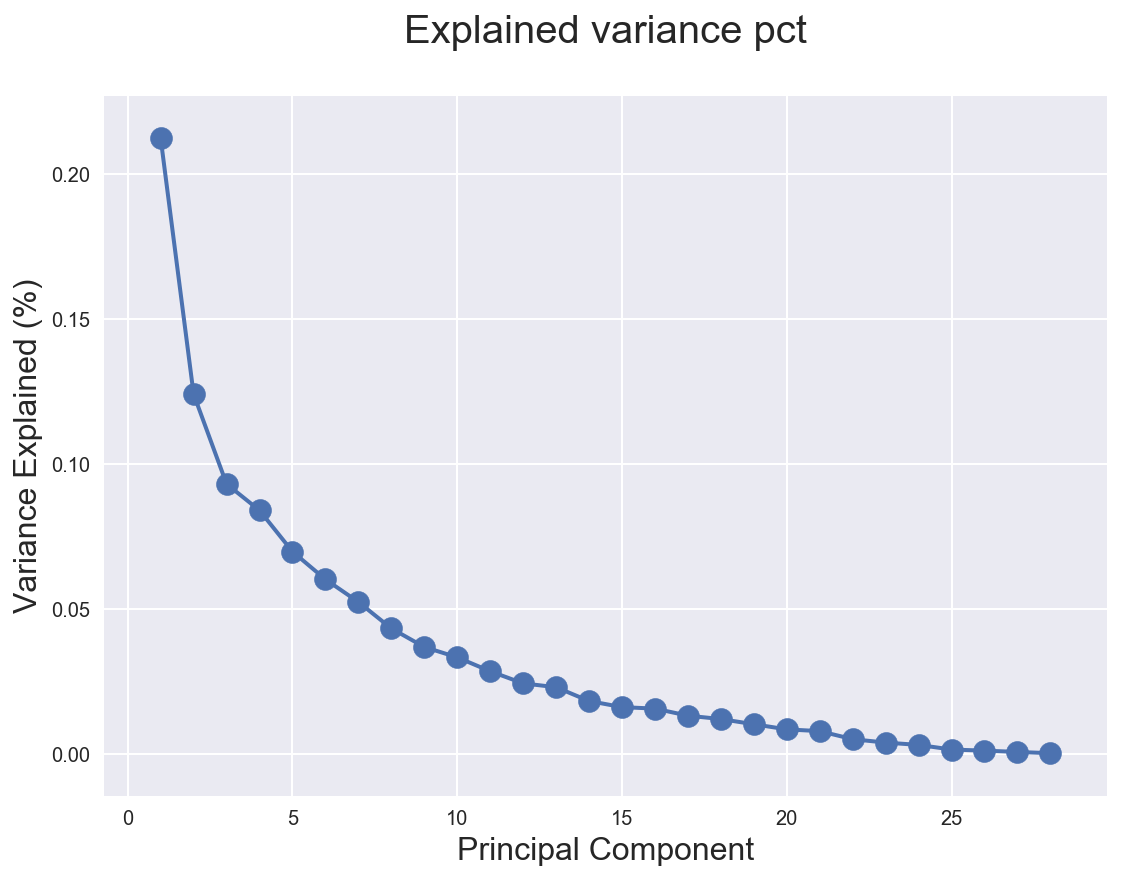

In [90]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1, len(exp_var_pct)+1), exp_var_pct, lw=2)
ax.scatter(range(1, len(exp_var_pct)+1), exp_var_pct, s=120)
ax.set_title('Explained variance pct\n', fontsize=20)
ax.set_xlabel('Principal Component', fontsize=16)
ax.set_ylabel('Variance Explained (%)', fontsize=16)
plt.show()

In [91]:
# Check PC1 to PC6
#PC1: mean of stint 1 and 2 length below average, range length of stint 1 and 2 below average, stint 1 S abv avg
#PC2: mean of stint 3 and 4 length below average, range length of stint 3 and 4 below average stint 1 M abv ag
#PC3: Count of intermediate tyres used above average
#PC5: I, M, tyre count below average for all stints
#PC6: US, SS tyre count below average for all stints

pc1to6 = pd.DataFrame({'PC1': pca.components_[0], 'PC2': pca.components_[1], 
              'PC3': pca.components_[2], 'PC4': pca.components_[3], 
              'PC5': pca.components_[4], 'PC6': pca.components_[5]},
             index=clean_new.iloc[:,2:].columns)
pc1to6 

PC1       PC2       PC3       PC4       PC5  \
mean_1               -0.282724  0.073980 -0.115484 -0.139137 -0.064110   
mean_2               -0.230578  0.111804 -0.291287 -0.188862 -0.040311   
mean_3                0.273318 -0.077275  0.171998  0.114120 -0.060671   
mean_4                0.220009 -0.096680  0.018109 -0.252945  0.388417   
range length_1       -0.187405  0.104358 -0.113037  0.053568 -0.116308   
range length_2       -0.211638  0.068438 -0.201036  0.117647  0.007731   
range length_3        0.095895 -0.133851  0.239165  0.195896 -0.104642   
range length_4        0.183173 -0.038949  0.079717 -0.347225  0.131422   
count_1_Intermediate  0.037289 -0.018784  0.217801  0.003583 -0.195145   
count_1_Medium        0.161863  0.345402 -0.090093  0.204437  0.288999   
count_1_Soft          0.229589 -0.071595 -0.317271 -0.120133 -0.296885   
count_1_Super soft   -0.173428 -0.340743 -0.178708  0.222316  0.176167   
count_1_Ultra soft   -0.212944  0.087506  0.190448 -0.373575  0.098232   
count_2_Hard          0.109491  0.285803 -0.030911  0.227106  0.162295   
count_2_Intermediate  0.067709  0.075078  0.420222  0.152591 -0.197330   
count_2_Medium        0.232366  0.138227 -0.300910 -0.080236 -0.078445   
count_2_Soft         -0.069550 -0.398784 -0.158924  0.096239 -0.036001   
count_2_Super soft   -0.253678 -0.016340  0.114193 -0.312069  0.211252   
count_3_Intermediate  0.017259  0.197087  0.146126  0.245536 -0.007021   
count_3_Medium        0.320211  0.018761 -0.072265 -0.069276 -0.132943   
count_3_Soft          0.132668 -0.299313  0.032097 -0.075005 -0.098462   
count_3_Super soft   -0.093807 -0.341379  0.068984  0.218020  0.256750   
count_3_Ultra soft   -0.140006  0.076889  0.380586 -0.215814  0.001317   
count_3_Wet           0.016020  0.071508  0.184984  0.002732 -0.042291   
count_4_Hard          0.131049  0.210242 -0.037721  0.047524  0.440164   
count_4_Medium        0.300091  0.000310 -0.085122 -0.118324  0.144484   
count_4_Soft          0.253657 -0.134190 -0.005498 -0.276032 -0.114123   
count_4_Super soft    0.070659 -0.314447  0.064971  0.043193  0.327645   

                           PC6  
mean_1                0.091665  
mean_2               -0.063297  
mean_3               -0.251452  
mean_4                0.237624  
range length_1        0.331148  
range length_2        0.042573  
range length_3       -0.156205  
range length_4        0.338882  
count_1_Intermediate -0.001213  
count_1_Medium       -0.114860  
count_1_Soft         -0.049038  
count_1_Super soft    0.110611  
count_1_Ultra soft   -0.238258  
count_2_Hard         -0.115409  
count_2_Intermediate  0.209087  
count_2_Medium       -0.074953  
count_2_Soft          0.007196  
count_2_Super soft   -0.129609  
count_3_Intermediate  0.115879  
count_3_Medium       -0.015654  
count_3_Soft         -0.230615  
count_3_Super soft   -0.012787  
count_3_Ultra soft   -0.231894  
count_3_Wet           0.564016  
count_4_Hard         -0.051889  
count_4_Medium        0.011444  
count_4_Soft          0.098778  
count_4_Super soft    0.039885

### Print out the weights/eigenvectors (.components_ ) with their corresponding variables for PC1 to PC6

In [92]:
# Races where drivers favour Medium tyres, do not tend to use Super soft, Ultra Soft tyres, similarly short 1 and 2 stints
pc1to6[['PC1']].sort_values('PC1')

PC1
mean_1               -0.282724
count_2_Super soft   -0.253678
mean_2               -0.230578
count_1_Ultra soft   -0.212944
range length_2       -0.211638
range length_1       -0.187405
count_1_Super soft   -0.173428
count_3_Ultra soft   -0.140006
count_3_Super soft   -0.093807
count_2_Soft         -0.069550
count_3_Wet           0.016020
count_3_Intermediate  0.017259
count_1_Intermediate  0.037289
count_2_Intermediate  0.067709
count_4_Super soft    0.070659
range length_3        0.095895
count_2_Hard          0.109491
count_4_Hard          0.131049
count_3_Soft          0.132668
count_1_Medium        0.161863
range length_4        0.183173
mean_4                0.220009
count_1_Soft          0.229589
count_2_Medium        0.232366
count_4_Soft          0.253657
mean_3                0.273318
count_4_Medium        0.300091
count_3_Medium        0.320211

In [93]:
# Races where drivers do not tend to use Super soft, Soft tyres, short 3 and 4 stints
# Races where drivers favour the harder compounds, longer stint 1 and 2
pc1to6[['PC2']].sort_values('PC2')

PC2
count_2_Soft         -0.398784
count_3_Super soft   -0.341379
count_1_Super soft   -0.340743
count_4_Super soft   -0.314447
count_3_Soft         -0.299313
count_4_Soft         -0.134190
range length_3       -0.133851
mean_4               -0.096680
mean_3               -0.077275
count_1_Soft         -0.071595
range length_4       -0.038949
count_1_Intermediate -0.018784
count_2_Super soft   -0.016340
count_4_Medium        0.000310
count_3_Medium        0.018761
range length_2        0.068438
count_3_Wet           0.071508
mean_1                0.073980
count_2_Intermediate  0.075078
count_3_Ultra soft    0.076889
count_1_Ultra soft    0.087506
range length_1        0.104358
mean_2                0.111804
count_2_Medium        0.138227
count_3_Intermediate  0.197087
count_4_Hard          0.210242
count_2_Hard          0.285803
count_1_Medium        0.345402

In [94]:
# PC3: range length 3 abv avg, count 2 I abv avg, count 3 US, abv avg, count 1 S below avg, count 2 M below avg, 
# PC3: Description: races where most drivers tend to have similarly short first 2 stints that do no use SS, S and M.
# Intermediate tyres used in first, second stint (suggest rain early in the race), length of stint 3 varies greatly between drivers.
# Stint 3 lengths are long probably to make up for the short first 2 stints.
# No clear trend in which tyres are used for stint 3, suggesting rainy weather brings great unpredictability to race strategy.
pc1to6[['PC3']].sort_values('PC3')

PC3
count_1_Soft         -0.317271
count_2_Medium       -0.300910
mean_2               -0.291287
range length_2       -0.201036
count_1_Super soft   -0.178708
count_2_Soft         -0.158924
mean_1               -0.115484
range length_1       -0.113037
count_1_Medium       -0.090093
count_4_Medium       -0.085122
count_3_Medium       -0.072265
count_4_Hard         -0.037721
count_2_Hard         -0.030911
count_4_Soft         -0.005498
mean_4                0.018109
count_3_Soft          0.032097
count_4_Super soft    0.064971
count_3_Super soft    0.068984
range length_4        0.079717
count_2_Super soft    0.114193
count_3_Intermediate  0.146126
mean_3                0.171998
count_3_Wet           0.184984
count_1_Ultra soft    0.190448
count_1_Intermediate  0.217801
range length_3        0.239165
count_3_Ultra soft    0.380586
count_2_Intermediate  0.420222

In [95]:
# More predictable races. If SS, S, M is the mandatory set, short first stint of SS, then S, SS in long stint 3 (a 2 stop strategy is popular)
# If S,M,H is the mandatory set, short first stint of M, then H
# I tyres in stint 3 suggest starts to rain mid-race
pc1to6[['PC4']].sort_values('PC4')

PC4
count_1_Ultra soft   -0.373575
range length_4       -0.347225
count_2_Super soft   -0.312069
count_4_Soft         -0.276032
mean_4               -0.252945
count_3_Ultra soft   -0.215814
mean_2               -0.188862
mean_1               -0.139137
count_1_Soft         -0.120133
count_4_Medium       -0.118324
count_2_Medium       -0.080236
count_3_Soft         -0.075005
count_3_Medium       -0.069276
count_3_Wet           0.002732
count_1_Intermediate  0.003583
count_4_Super soft    0.043193
count_4_Hard          0.047524
range length_1        0.053568
count_2_Soft          0.096239
mean_3                0.114120
range length_2        0.117647
count_2_Intermediate  0.152591
range length_3        0.195896
count_1_Medium        0.204437
count_3_Super soft    0.218020
count_1_Super soft    0.222316
count_2_Hard          0.227106
count_3_Intermediate  0.245536

In [96]:
# Medium tyres used in short first stint, hard tyres are used in last stint. 
# PC5 Description: 3-stop strategy popular, with long last stint, SS popular option throughout race, 
# suggest races on tracks with high tyre stress
pc1to6[['PC5']].sort_values('PC5')

PC5
count_1_Soft         -0.296885
count_2_Intermediate -0.197330
count_1_Intermediate -0.195145
count_3_Medium       -0.132943
range length_1       -0.116308
count_4_Soft         -0.114123
range length_3       -0.104642
count_3_Soft         -0.098462
count_2_Medium       -0.078445
mean_1               -0.064110
mean_3               -0.060671
count_3_Wet          -0.042291
mean_2               -0.040311
count_2_Soft         -0.036001
count_3_Intermediate -0.007021
count_3_Ultra soft    0.001317
range length_2        0.007731
count_1_Ultra soft    0.098232
range length_4        0.131422
count_4_Medium        0.144484
count_2_Hard          0.162295
count_1_Super soft    0.176167
count_2_Super soft    0.211252
count_3_Super soft    0.256750
count_1_Medium        0.288999
count_4_Super soft    0.327645
mean_4                0.388417
count_4_Hard          0.440164

In [97]:
# PC6 Description: short 3rd stints, 4 stints overall, suggesting races that rain mid-race briefly 
# High count of pitstops not due to tyre stress, but because of the weather
pc1to6[['PC6']].sort_values('PC6')

PC6
mean_3               -0.251452
count_1_Ultra soft   -0.238258
count_3_Ultra soft   -0.231894
count_3_Soft         -0.230615
range length_3       -0.156205
count_2_Super soft   -0.129609
count_2_Hard         -0.115409
count_1_Medium       -0.114860
count_2_Medium       -0.074953
mean_2               -0.063297
count_4_Hard         -0.051889
count_1_Soft         -0.049038
count_3_Medium       -0.015654
count_3_Super soft   -0.012787
count_1_Intermediate -0.001213
count_2_Soft          0.007196
count_4_Medium        0.011444
count_4_Super soft    0.039885
range length_2        0.042573
mean_1                0.091665
count_4_Soft          0.098778
count_1_Super soft    0.110611
count_3_Intermediate  0.115879
count_2_Intermediate  0.209087
mean_4                0.237624
range length_1        0.331148
range length_4        0.338882
count_3_Wet           0.564016

In [99]:
pcs.index = pd.MultiIndex.from_arrays(pcs[['year', 'name']].values.T, names=['idx1', 'idx2'])
pcs = pcs.drop(['year', 'name'], axis=1)
pcs

PC1       PC2       PC3       PC4  \
idx1 idx2                                                               
2015 Australian Grand Prix    -0.310429  1.483451 -1.439806 -0.419741   
     Austrian Grand Prix      -2.829867 -0.052556 -1.768473  0.806640   
     Bahrain Grand Prix        2.573474 -0.278443 -0.830144 -0.164246   
     Belgian Grand Prix        2.535025 -0.455233 -0.609053 -0.325607   
     Brazilian Grand Prix      5.373498  0.438823 -1.287835 -3.435468   
     British Grand Prix        0.124983  4.993164  0.769760  4.063460   
     Canadian Grand Prix      -2.502321 -0.495245 -1.683052  0.238853   
     Chinese Grand Prix        2.114052  0.345968 -0.958118  0.014116   
     Hungarian Grand Prix      4.965260 -1.734319 -0.863546 -3.959274   
     Italian Grand Prix        0.214638  1.455017 -1.947425 -0.440108   
     Japanese Grand Prix       2.577059  3.806281 -0.259770  1.932928   
     Malaysian Grand Prix      4.961512  4.126668 -0.478815  0.212808   
     Mexican Grand Prix        1.619443  1.186168 -2.060020 -0.706383   
     Monaco Grand Prix        -3.008835 -1.479368 -1.127087  1.471563   
     Russian Grand Prix       -1.559662 -0.347182 -0.800655  0.640577   
     Singapore Grand Prix     -0.260696 -2.850345  0.271334  0.705732   
     Spanish Grand Prix        2.682936  3.736299 -1.138167  1.312274   
     United States Grand Prix  1.976418 -1.230341  2.671469 -0.150982   
2016 Abu Dhabi Grand Prix      0.128503 -2.096506  0.805936  0.516952   
     Australian Grand Prix     1.328947 -1.571113  0.204203  0.946249   
     Austrian Grand Prix      -2.113895 -1.304743 -0.363119  0.836639   
     Azerbaijan Grand Prix    -0.769544 -1.952453 -0.187300  2.022574   
     Bahrain Grand Prix        2.117359 -3.831484  0.334256 -0.500903   
     Belgian Grand Prix        2.324882 -0.866911 -0.554029  0.452950   
     Brazilian Grand Prix      0.712557  1.857861  3.605144  0.048033   
     British Grand Prix        3.143227  1.160820  3.378182  1.290369   
     Canadian Grand Prix      -1.306695 -0.324859  1.525374 -1.173117   
     Chinese Grand Prix        4.677427 -3.369155 -0.399404 -1.709858   
     Hungarian Grand Prix      0.003127 -2.405650 -0.357268  0.784900   
     Italian Grand Prix        0.053674 -1.962030 -0.098420  0.994346   
     Japanese Grand Prix       1.528156  2.157046 -0.380749  1.498606   
     Malaysian Grand Prix      2.203158  1.098275 -0.527623  0.273066   
     Mexican Grand Prix       -0.698230  1.300361 -3.007900 -0.351992   
     Monaco Grand Prix         0.676504 -0.240770  5.307792  2.414038   
     Russian Grand Prix       -1.720034 -0.803191 -1.412814  1.014373   
     Singapore Grand Prix      0.131827 -1.641532  3.067348 -3.332106   
     Spanish Grand Prix        3.633539  0.413355 -1.329197 -0.369380   
     United States Grand Prix  1.689665 -1.254195 -0.494407  1.011838   
2017 Abu Dhabi Grand Prix     -3.085428  1.535774  0.715476 -2.304085   
     Australian Grand Prix    -2.389075  1.117448  0.533559 -1.653753   
     Austrian Grand Prix      -2.802530  1.250813 -0.101027 -1.857904   
     Azerbaijan Grand Prix    -0.735902 -3.938002  0.810032  2.519352   
     Bahrain Grand Prix       -0.918351 -1.613412  0.334049  0.789559   
     Belgian Grand Prix       -1.536895 -0.294958  2.324881 -0.769645   
     Brazilian Grand Prix     -1.203801 -0.920877  0.061231  0.832619   
     British Grand Prix       -1.884714 -0.973336 -0.857379  0.666289   
     Canadian Grand Prix      -3.283995  1.751553  0.438915 -2.178251   
     Hungarian Grand Prix     -2.634050 -0.420359 -1.564052  0.503787   
     Italian Grand Prix       -2.306093 -0.387473 -1.337897  0.684072   
     Japanese Grand Prix      -1.688872 -0.498211 -0.999106  0.199657   
     Malaysian Grand Prix     -3.127410  0.065808 -1.985262  0.867673   
     Mexican Grand Prix       -3.743209  1.421303  0.034027 -1.598455   
     Monaco Grand Prix        -4.247411  2.024456  1.300190 -3.269889   
     Russian Grand Pr

#### Plot PC1 vs. PC2. Which races are notable on each component?

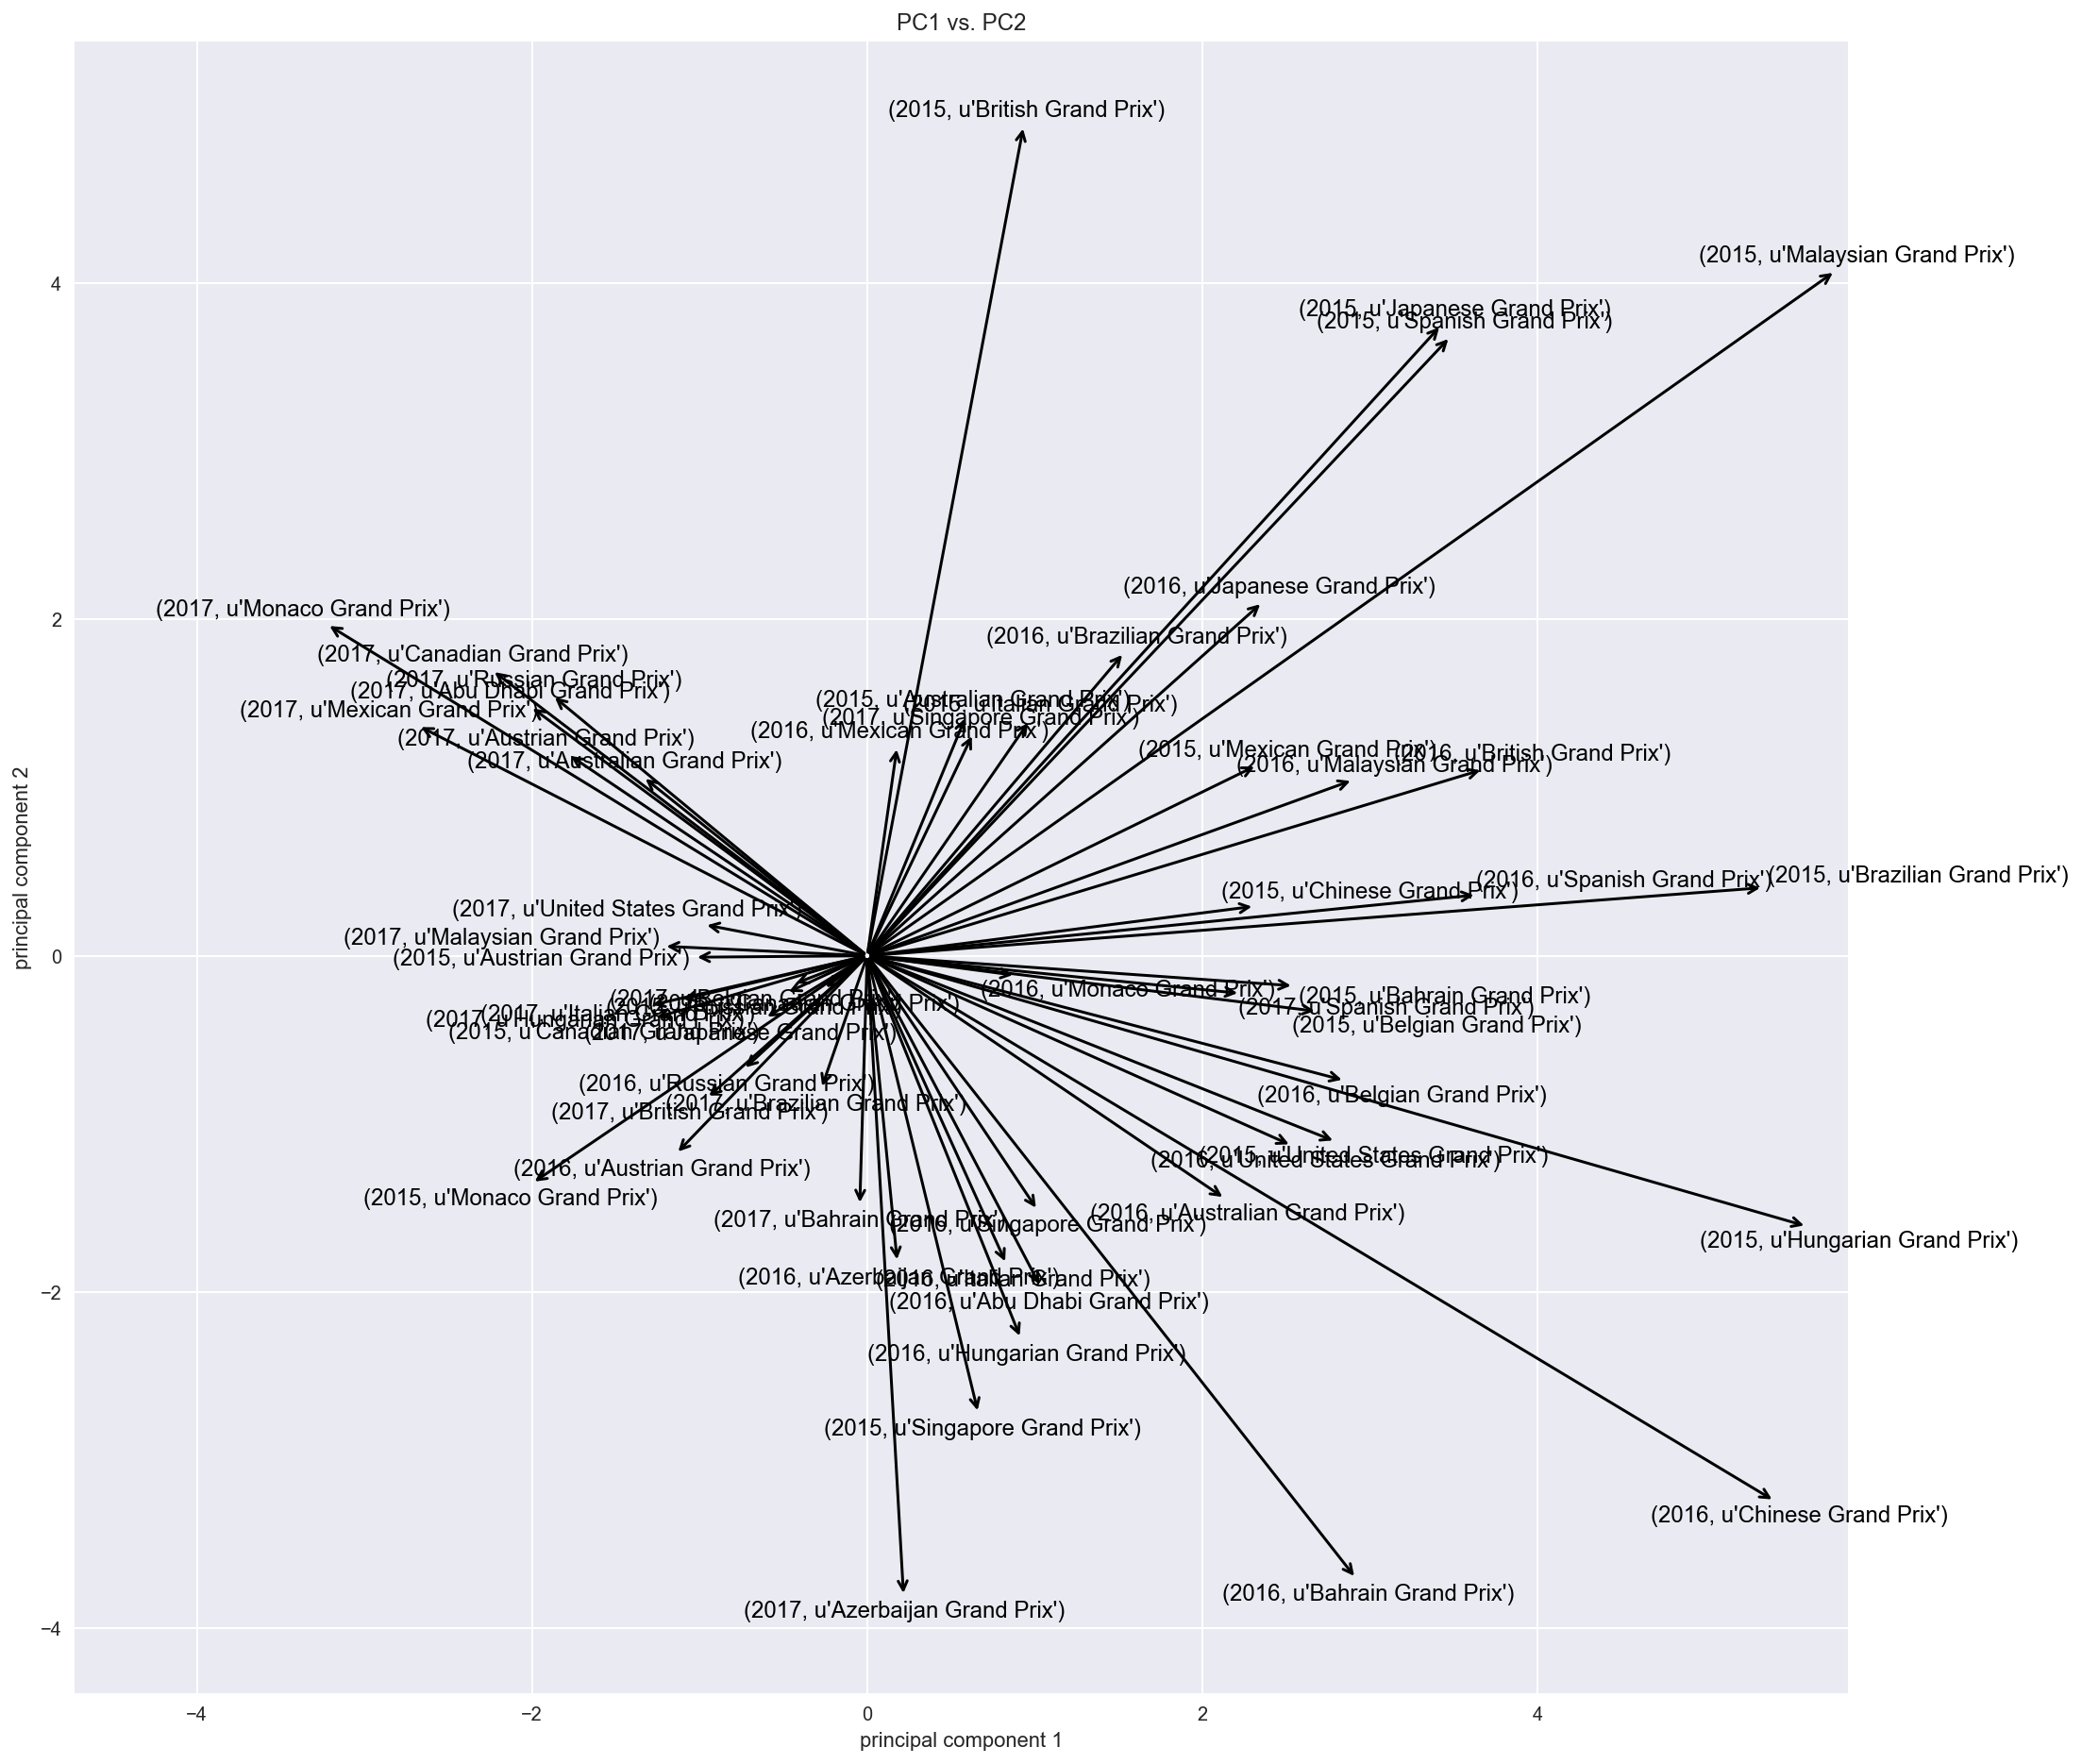

In [100]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(pcs.PC1.values, pcs.PC2.values, s=0)

for i, txt in enumerate(pcs.index.values):
    ax.annotate(txt, (0, 0), (pcs.PC1.values[i], pcs.PC2.values[i]),
            arrowprops=dict(arrowstyle='<-', color='black', linewidth=1.5),
            xycoords='data', textcoords='data', fontsize=12, color="black")

ax.set_title('PC1 vs. PC2')
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
plt.show()

In [101]:
# Findings: Only some races seems to follow the same trend of long stint 1 and 2 and short stint 3 and 4,
# with the exception of street circuits like Azerbaijan Grand Prix, Singapore Grand Prix 
# Bahrain, United States, Hungarian see similar strategy over the years

# almost all 2017 races seem to show difference from their 2015 and 2016 races

#### Plot PC3 vs. PC4. Which races are notable on each component?

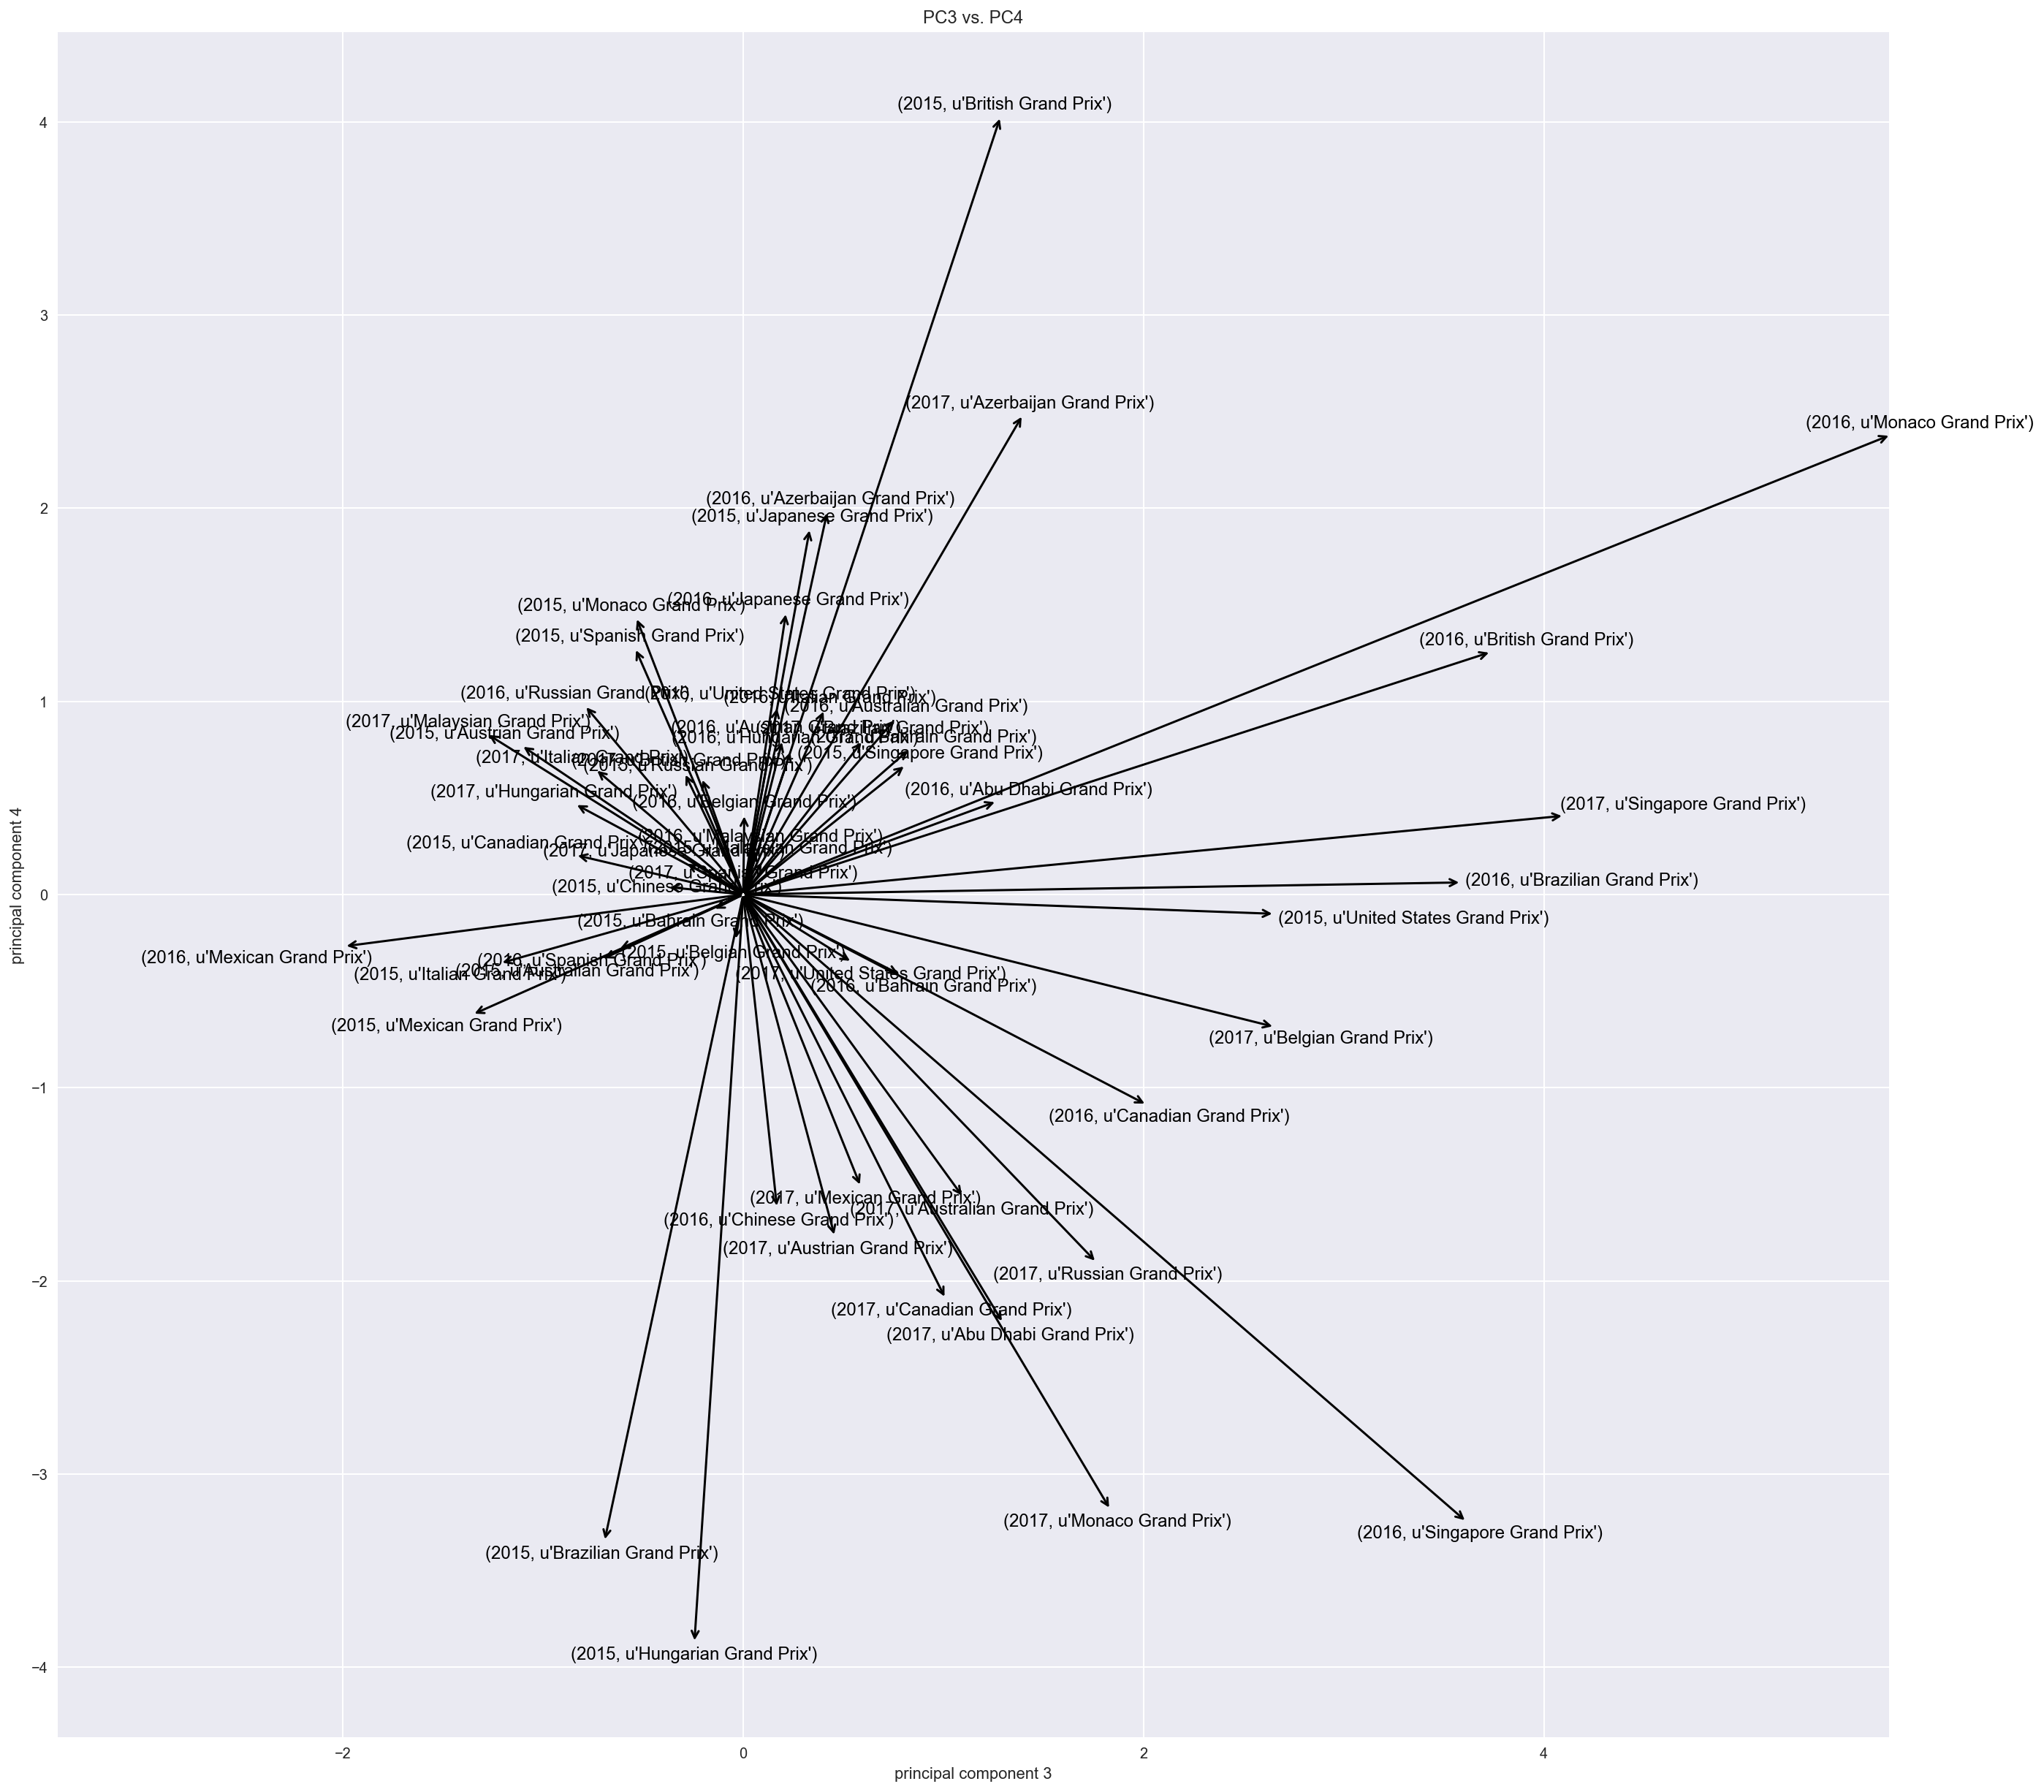

In [102]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(pcs.PC3.values, pcs.PC4.values, s=0)

for i, txt in enumerate(pcs.index.values):
    ax.annotate(txt, (0, 0), (pcs.PC3.values[i], pcs.PC4.values[i]),
            arrowprops=dict(arrowstyle='<-', color='black', linewidth=1.5),
            xycoords='data', textcoords='data', fontsize=12, color="black")

ax.set_title('PC3 vs. PC4')
ax.set_xlabel('principal component 3')
ax.set_ylabel('principal component 4')
plt.show()

In [103]:
#Findings: Races located in the top right hand corner of graph suffered wet weather
# Many races clumped together in the top left hand corner. These are the races in dry conditions 
# and having relatively predicablte race strategy of either S, M, H or SS, S, M

#### Plot PC5 vs. PC6. Which races are notable on each component?

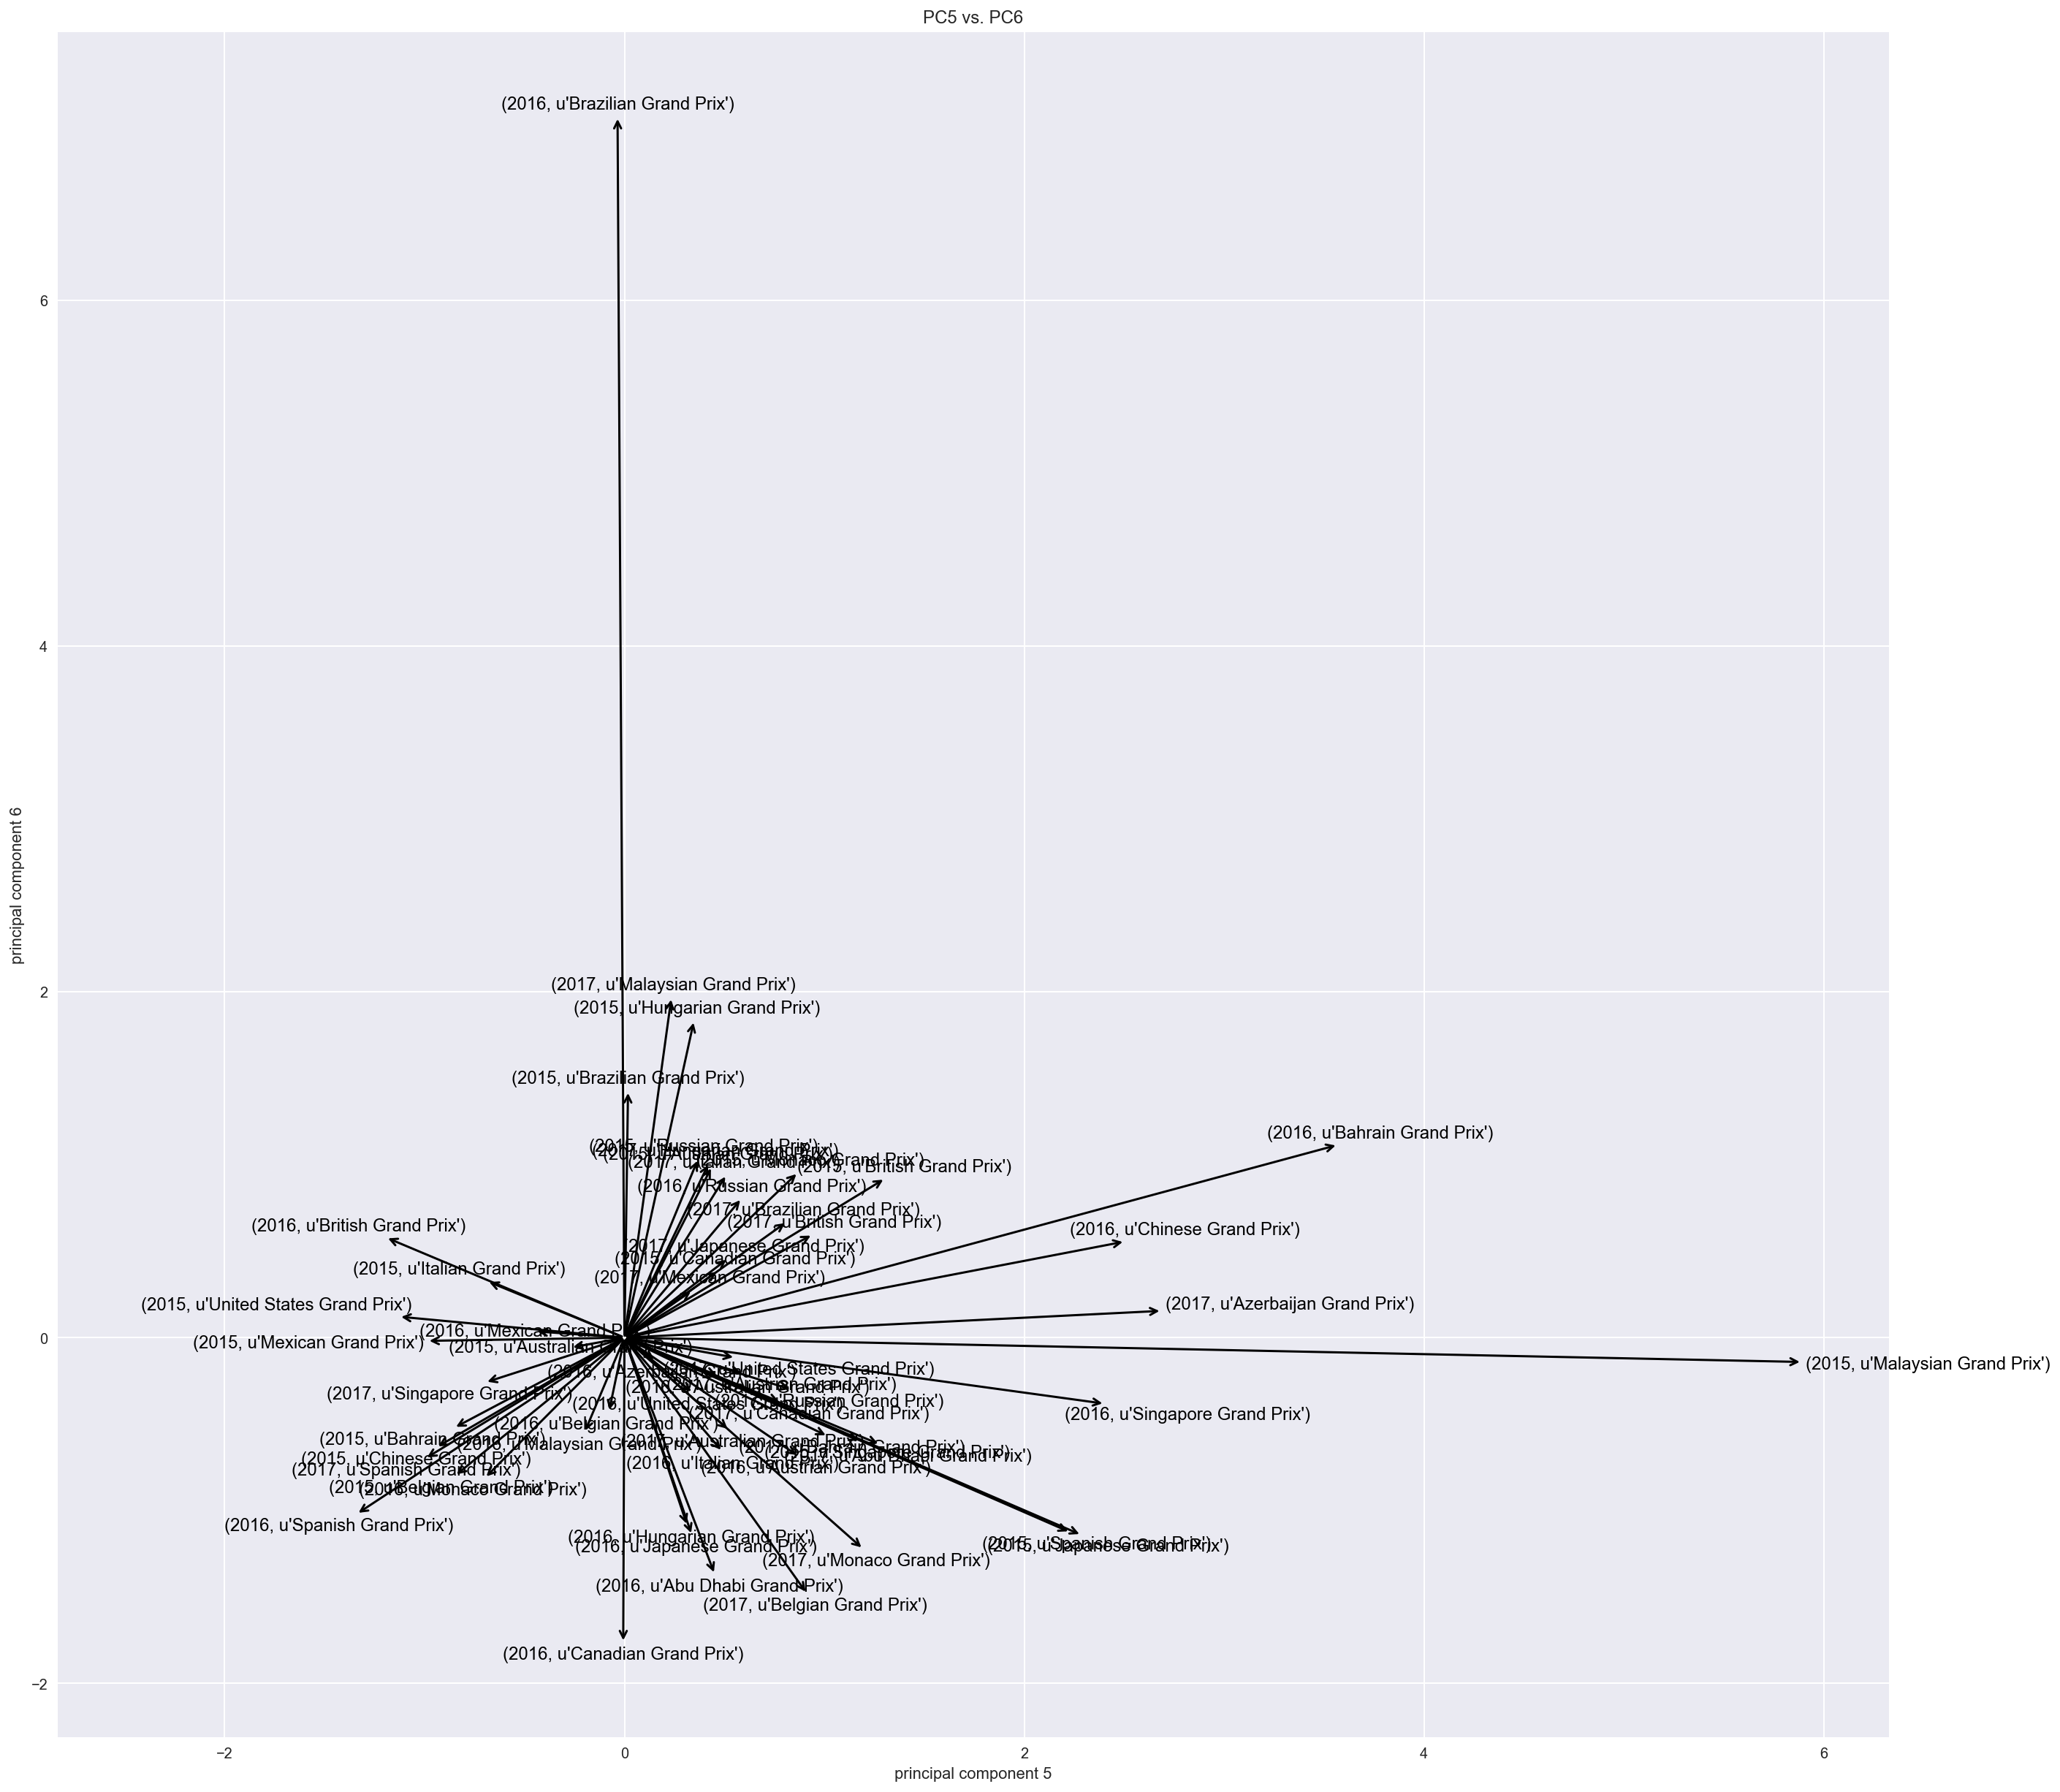

In [104]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(pcs.PC5.values, pcs.PC6.values, s=0)

for i, txt in enumerate(pcs.index.values):
    ax.annotate(txt, (0, 0), (pcs.PC5.values[i], pcs.PC6.values[i]),
            arrowprops=dict(arrowstyle='<-', color='black', linewidth=1.5),
            xycoords='data', textcoords='data', fontsize=12, color="black")

ax.set_title('PC5 vs. PC6')
ax.set_xlabel('principal component 5')
ax.set_ylabel('principal component 6')
plt.show()

### To find homogeneous subgroups among the observations, perform K-Means Clustering on PCA-transformed dataset

In [105]:
opt_cluster(ran, pcs.iloc[:,0:6])

k                  c3
silhouette    0.48901
processing    default
Name: 1, dtype: object

/Users/dianaow/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


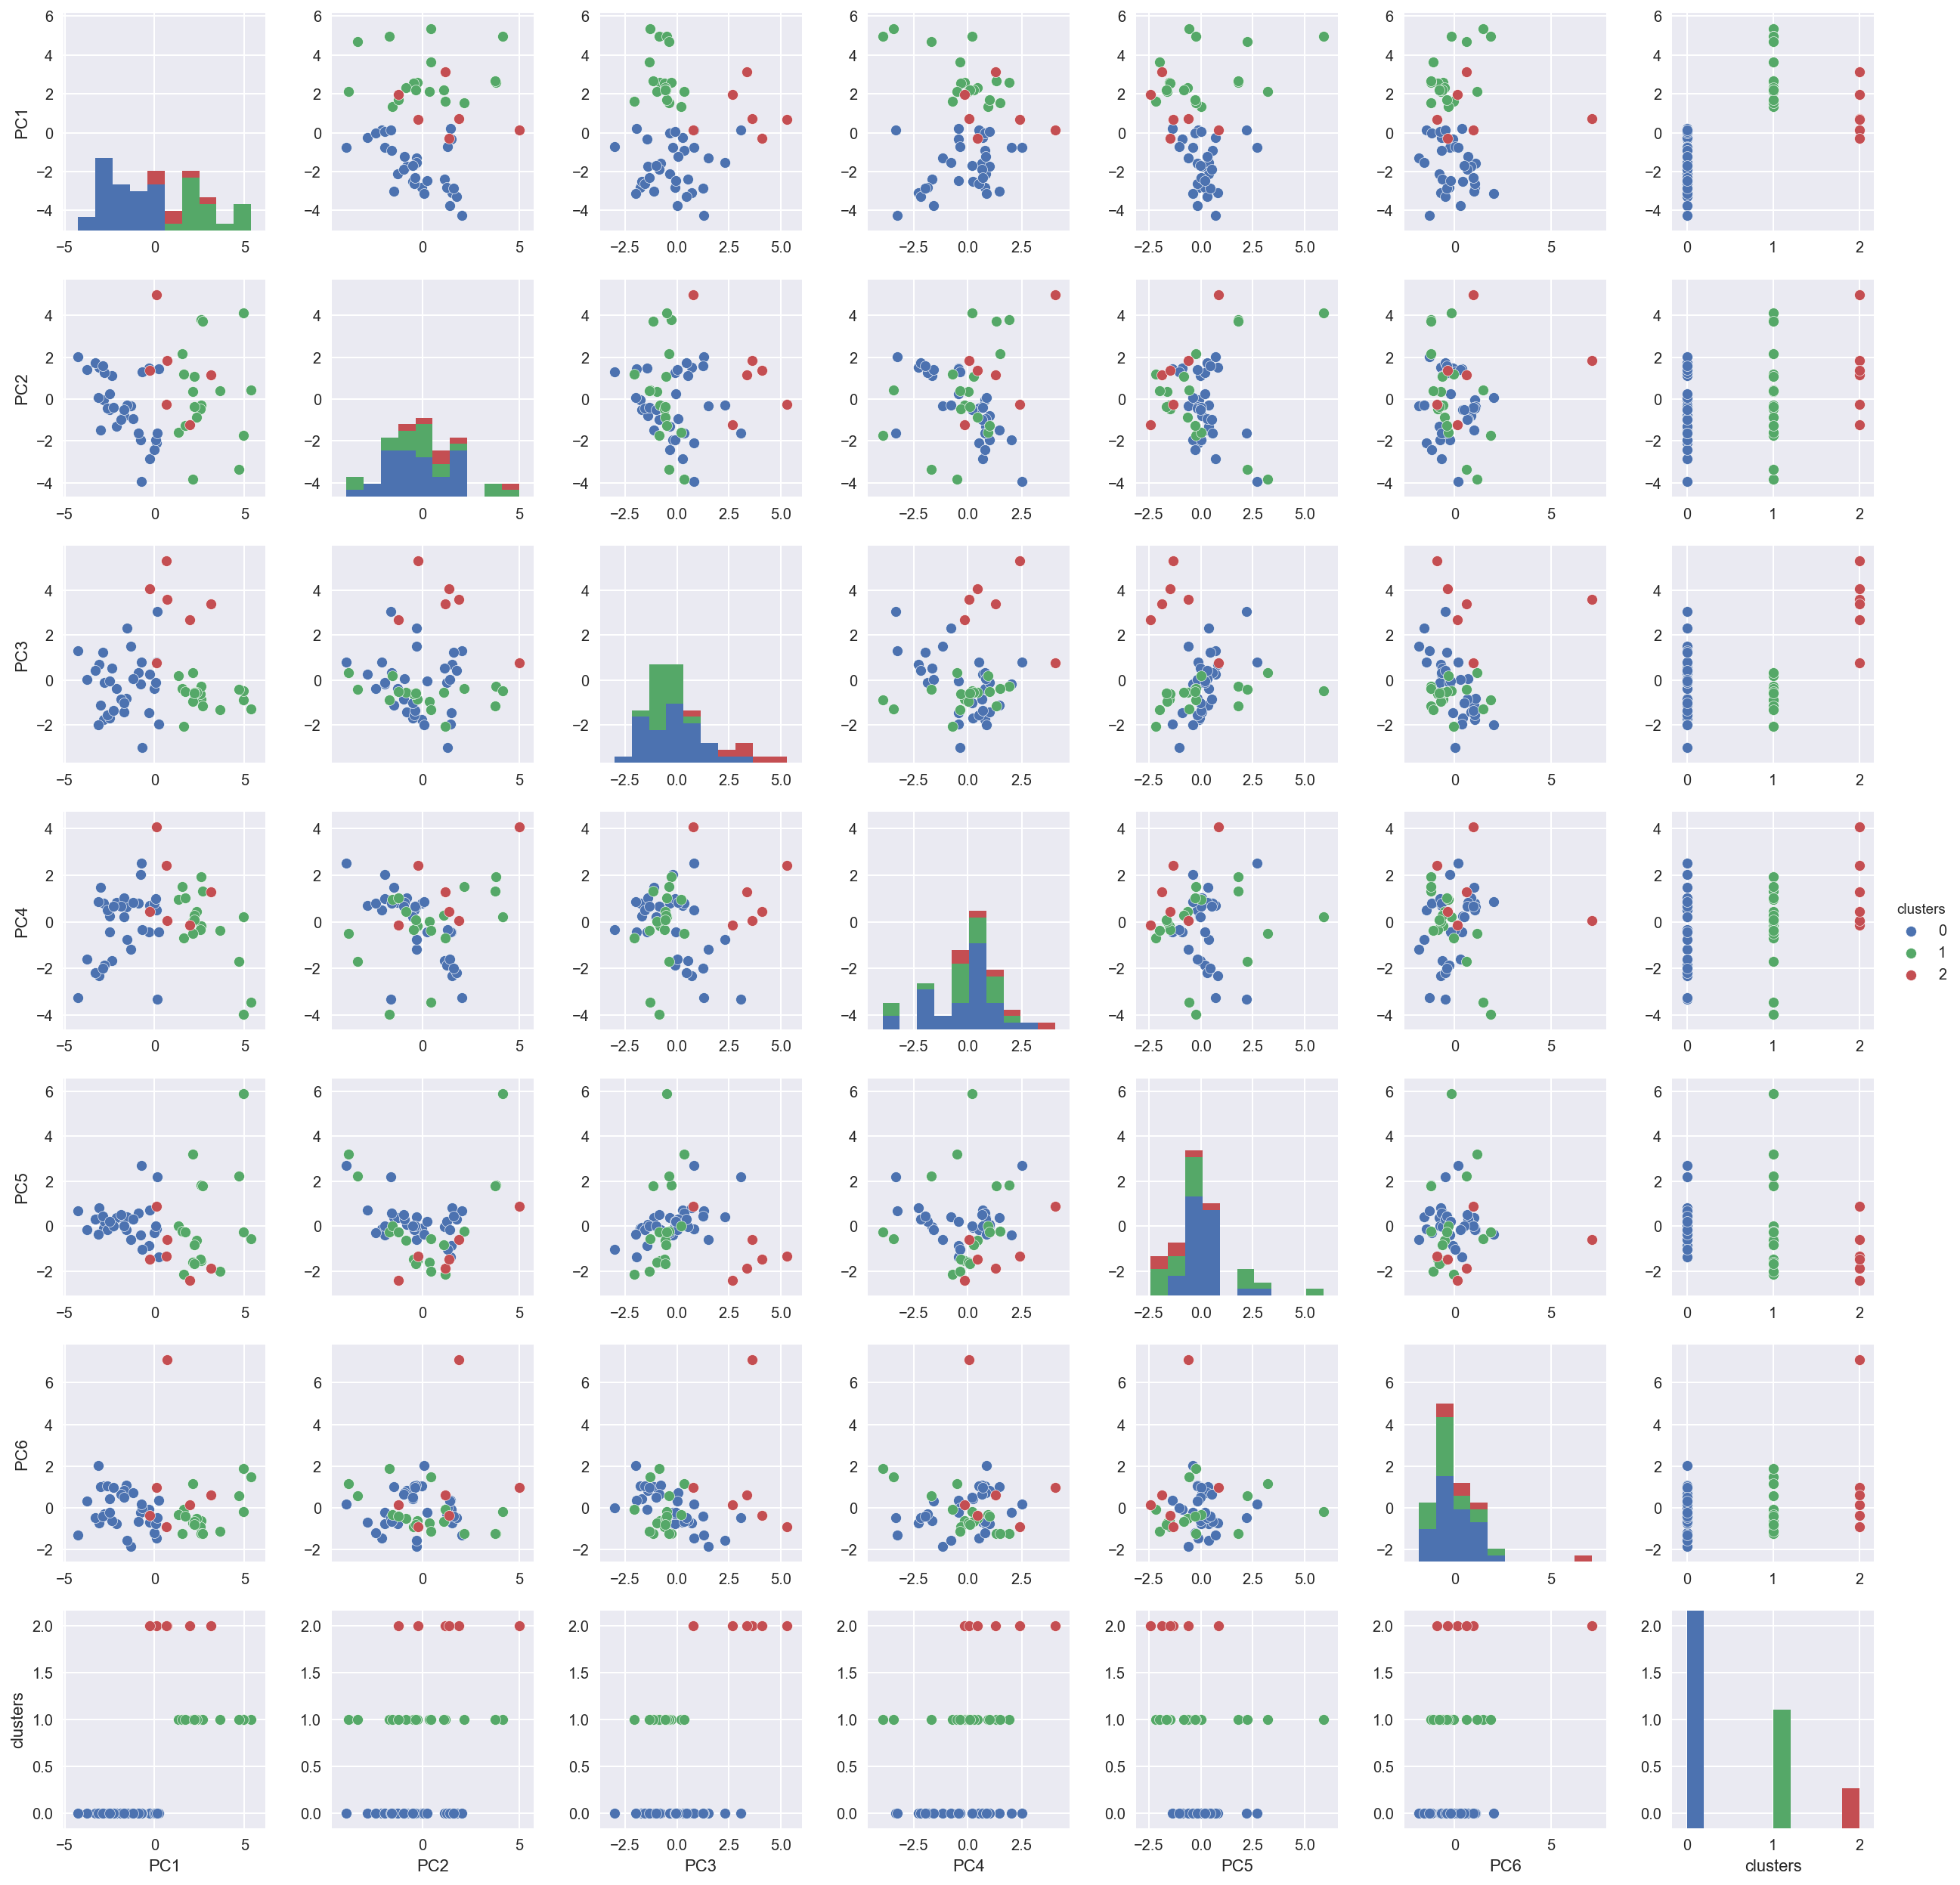

In [109]:
# build the model with the found optimal parameters

k_mean_opt = KMeans(n_clusters=3)
k_mean_opt.fit(pcs.iloc[:,0:6])
labels_opt = k_mean_opt.labels_

X_k = pcs.iloc[:,0:6]

X_k['clusters']=labels_opt
sns.pairplot(data=X_k, hue='clusters')

In [110]:
X_k.reset_index().sort_values("clusters")

idx1                      idx2       PC1       PC2       PC3       PC4  \
0   2015     Australian Grand Prix -0.310429  1.483451 -1.439806 -0.419741   
32  2016        Mexican Grand Prix -0.698230  1.300361 -3.007900 -0.351992   
34  2016        Russian Grand Prix -1.720034 -0.803191 -1.412814  1.014373   
35  2016      Singapore Grand Prix  0.131827 -1.641532  3.067348 -3.332106   
38  2017      Abu Dhabi Grand Prix -3.085428  1.535774  0.715476 -2.304085   
39  2017     Australian Grand Prix -2.389075  1.117448  0.533559 -1.653753   
40  2017       Austrian Grand Prix -2.802530  1.250813 -0.101027 -1.857904   
41  2017     Azerbaijan Grand Prix -0.735902 -3.938002  0.810032  2.519352   
42  2017        Bahrain Grand Prix -0.918351 -1.613412  0.334049  0.789559   
43  2017        Belgian Grand Prix -1.536895 -0.294958  2.324881 -0.769645   
44  2017      Brazilian Grand Prix -1.203801 -0.920877  0.061231  0.832619   
45  2017        British Grand Prix -1.884714 -0.973336 -0.857379  0.666289   
46  2017       Canadian Grand Prix -3.283995  1.751553  0.438915 -2.178251   
47  2017      Hungarian Grand Prix -2.634050 -0.420359 -1.564052  0.503787   
48  2017        Italian Grand Prix -2.306093 -0.387473 -1.337897  0.684072   
49  2017       Japanese Grand Prix -1.688872 -0.498211 -0.999106  0.199657   
50  2017      Malaysian Grand Prix -3.127410  0.065808 -1.985262  0.867673   
51  2017        Mexican Grand Prix -3.743209  1.421303  0.034027 -1.598455   
52  2017         Monaco Grand Prix -4.247411  2.024456  1.300190 -3.269889   
53  2017        Russian Grand Prix -2.869204  1.601664  1.248772 -1.989599   
29  2016        Italian Grand Prix  0.053674 -1.962030 -0.098420  0.994346   
26  2016       Canadian Grand Prix -1.306695 -0.324859  1.525374 -1.173117   
28  2016      Hungarian Grand Prix  0.003127 -2.405650 -0.357268  0.784900   
15  2015      Singapore Grand Prix -0.260696 -2.850345  0.271334  0.705732   
1   2015       Austrian Grand Prix -2.829867 -0.052556 -1.768473  0.806640   
6   2015       Canadian Grand Prix -2.502321 -0.495245 -1.683052  0.238853   
9   2015        Italian Grand Prix  0.214638  1.455017 -1.947425 -0.440108   
13  2015         Monaco Grand Prix -3.008835 -1.479368 -1.127087  1.471563   
14  2015        Russian Grand Prix -1.559662 -0.347182 -0.800655  0.640577   
18  2016      Abu Dhabi Grand Prix  0.128503 -2.096506  0.805936  0.516952   
56  2017  United States Grand Prix -2.478735  0.236517 -0.039568 -0.435043   
20  2016       Austrian Grand Prix -2.113895 -1.304743 -0.363119  0.836639   
21  2016     Azerbaijan Grand Prix -0.769544 -1.952453 -0.187300  2.022574   
31  2016      Malaysian Grand Prix  2.203158  1.098275 -0.527623  0.273066   
2   2015        Bahrain Grand Prix  2.573474 -0.278443 -0.830144 -0.164246   
3   2015        Belgian Grand Prix  2.535025 -0.455233 -0.609053 -0.325607   
4   2015      Brazilian Grand Prix  5.373498  0.438823 -1.287835 -3.435468   
7   2015        Chinese Grand Prix  2.114052  0.345968 -0.958118  0.014116   
8   2015      Hungarian Grand Prix  4.965260 -1.734319 -0.863546 -3.959274   
10  2015       Japanese Grand Prix  2.577059  3.806281 -0.259770  1.932928   
30  2016       Japanese Grand Prix  1.528156  2.157046 -0.380749  1.498606   
12  2015        Mexican Grand Prix  1.619443  1.186168 -2.060020 -0.706383   
11  2015      Malaysian Grand Prix  4.961512  4.126668 -0.478815  0.212808   
55  2017        Spanish Grand Prix  2.215652 -0.347886 -0.573954  0.087091   
22  2016        Bahrain Grand Prix  2.117359 -3.831484  0.334256 -0.500903   
16  2015        Spanish Grand Prix  2.682936  3.736299 -1.138167  1.312274   
37  2016  United States Grand Prix  1.689665 -1.254195 -0.494407  1.011838   
36  2016        Spanish Grand Prix  3.633539  0.413355 -1.329197 -0.369380   
19  2016     Australian Grand Prix  1.328947 -1.571113  0.204203  0.946249   
27  2016        Chinese Grand Prix  4.677427 -3.369155 -0.399404 -1.709858   
23  2016        Belgian Gr

### What do each cluster represent?

#### Cluster 0: Mainly consist of races where most drivers utillized 1-stop strategy.   (Note: Mostly consist of 2017 races!)
#### Cluster 1: Races where drivers utilized  2-stop strategy
#### Cluster 2: Wet weather races from 2015 to 2017

### Findings: Race strategy (defined as the tyres used by each driver and stint lengths) differ on the same race track between years.

#### - 2017 races seem to follow a complete different strategy from 2015 and 2016 races. A check on the actual data shows that in 2017, a 1-stop strategy was preferred in most races, where as 2-stop or even 3 stops strategies preferred in 2015 and 2016.
#### - This is inline with Pirelli's relevation that tyres are more durable in 2017